##Saving File In Drive

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installations (Restart kernel after this is done)

In [11]:
%%capture
!sudo apt update
!sudo apt install libcairo2-dev \
    texlive texlive-latex-extra texlive-fonts-extra \
    texlive-latex-recommended texlive-science \
    tipa libpango1.0-dev
!pip install manim
!pip install IPython==8.21.0

In [12]:
from IPython.display import display, Markdown # Import display and Markdown

# Setup

## Generate animations

In [14]:
import logging

from manim import *
import numpy as np
import os
import glob
import time # Added: Import the time module for time.sleep()
from IPython.display import Video, display # For displaying the video in Colab

import keras
import matplotlib.pyplot as plt


# Set the log level to WARNING to suppress INFO logs
logging.getLogger("manim").setLevel(logging.WARNING)

ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.11/dist-packages/numpy/_core/umath.py)

In [ ]:
def display_video(path):
  video_files_meaning = glob.glob(path, recursive=True)

  if video_files_meaning:
      latest_video_meaning = max(video_files_meaning, key=os.path.getctime)
      # Corrected: Added width parameter for display size
      display(Video(latest_video_meaning, embed=True,
                    html_attributes="controls autoplay loop", width=600))
  else:
      raise ValueError('Cannot locate video file')

In [ ]:
class DotProductAnimation(Scene):
    def construct(self):
        # --- Scene Setup: Axes and Initial Vectors ---
        axes = Axes(
            x_range=[-5, 5, 1],
            y_range=[-5, 5, 1],
            x_length=10,
            y_length=10,
            axis_config={"color": GREY_A},
            tips=False
        ).add_coordinates()
        self.add(axes)

        v_coords = np.array([3.0, 2.0, 0.0])
        w_coords = np.array([1.5, 3.0, 0.0])

        vector_v = Vector(v_coords, color=BLUE, buff=0).set_opacity(0.9)
        vector_w = Vector(w_coords, color=RED, buff=0).set_opacity(0.9)

        # Labels positioned to stay out of the way
        v_label = MathTex(r"\vec{v}").next_to(vector_v.get_end(), RIGHT + DOWN, buff=0.1).set_color(BLUE)
        w_label = MathTex(r"\vec{w}").next_to(vector_w.get_end(), UP + LEFT, buff=0.1).set_color(RED)

        self.play(
            Create(vector_v), Write(v_label),
            Create(vector_w), Write(w_label)
        )
        self.wait(1)

        # --- Introduce the Formulas (positioned at corners, then moved to center top) ---
        geo_formula = MathTex(r"\vec{v} \cdot \vec{w} = ||\vec{v}|| \cdot ||\vec{w}|| \cos(\theta)").to_corner(UL)
        alg_formula = MathTex(r"\vec{v} \cdot \vec{w} = v_x w_x + v_y w_y").to_corner(UR)

        self.play(
            Write(geo_formula),
            Write(alg_formula)
        )
        self.wait(1)

        # --- Geometric Interpretation: Projection ---
        # Move geo_formula to center top, fade out algebraic formula
        self.play(
            FadeOut(alg_formula),
            geo_formula.animate.to_edge(UP)
        )
        self.wait(0.5)

        line_w_extension = Line(ORIGIN, vector_w.get_end() * 3, color=RED_A, stroke_width=2, z_index=-1).set_opacity(0.5)
        self.play(Create(line_w_extension))
        self.wait(0.5)

        dot_prod_val = np.dot(v_coords, w_coords)
        mag_w_squared = np.linalg.norm(w_coords)**2

        projection_scalar = dot_prod_val / mag_w_squared
        projected_v_coords = w_coords * projection_scalar

        projected_vector_v = Vector(projected_v_coords, color=GREEN, buff=0).set_opacity(0.9)

        projection_line = DashedLine(vector_v.get_end(), projected_vector_v.get_end(), color=YELLOW_D, stroke_width=3)

        right_angle_symbol = Square(
            side_length=0.2,
            color=YELLOW_D,
            fill_opacity=0
        ).move_to(projected_vector_v.get_end() + np.array([-0.1, -0.1, 0]))
        right_angle_symbol.rotate(vector_w.get_angle())

        self.play(
            Create(projection_line),
            Create(right_angle_symbol),
            vector_v.animate.set_opacity(0.2)
        )
        self.wait(0.5)

        self.play(
            Transform(vector_v, projected_vector_v),
            v_label.animate.next_to(projected_vector_v.get_end(), DOWN, buff=0.1).set_color(GREEN)
        )
        self.wait(1)

        scalar_proj_label = MathTex(r"||\vec{v}|| \cos(\theta)", font_size=32).next_to(projected_vector_v, DOWN, buff=0.2).set_color(GREEN)
        self.play(Write(scalar_proj_label))
        self.wait(1)

        # Explanation text positioned at the bottom
        geometric_explanation_line1 = Text("The dot product is the length of the projection", font_size=28)
        geometric_explanation_line2 = Text("of one vector onto the other...", font_size=28).next_to(geometric_explanation_line1, DOWN, buff=0.2, aligned_edge=LEFT)
        geometric_explanation_line3 = Text("multiplied by the length of the vector it was projected onto.", font_size=28).next_to(geometric_explanation_line2, DOWN, buff=0.2, aligned_edge=LEFT)

        geometric_explanation = VGroup(
            geometric_explanation_line1,
            geometric_explanation_line2,
            geometric_explanation_line3
        ).arrange(DOWN, aligned_edge=LEFT).to_edge(DOWN).set_color(YELLOW_D)

        self.play(Write(geometric_explanation))
        self.wait(2)

        mag_v_cos_theta = np.linalg.norm(projected_v_coords)
        mag_w = np.linalg.norm(w_coords)

        updated_geo_formula = MathTex(r"\vec{v} \cdot \vec{w} = (", f"{mag_v_cos_theta:.2f}", r") \cdot (", f"{mag_w:.2f}", r") = ", f"{dot_prod_val:.2f}").to_edge(UP)

        self.play(
            FadeOut(geometric_explanation), # Fade out explanation to make space for next step
            ReplacementTransform(geo_formula, updated_geo_formula),
            FadeOut(scalar_proj_label),
            Flash(projected_vector_v, color=GREEN),
            Flash(vector_w, color=RED)
        )
        self.wait(2)

        # --- Reset for Algebraic Interpretation ---
        self.play(
            FadeOut(line_w_extension, projection_line, right_angle_symbol),
            vector_v.animate.become(Vector(v_coords, color=BLUE, buff=0).set_opacity(0.9)),
            v_label.animate.next_to(vector_v.get_end(), RIGHT + DOWN, buff=0.1).set_color(BLUE),
            updated_geo_formula.animate.become(alg_formula.copy().to_edge(UP)) # Restore algebraic formula to top
        )
        self.wait(1)

        # --- Algebraic Interpretation: Component-wise Multiplication ---

        v_x_comp = Line(ORIGIN, [v_coords[0], 0, 0], color=BLUE_D, stroke_width=4)
        v_y_comp = Line([v_coords[0], 0, 0], v_coords, color=BLUE_D, stroke_width=4)

        w_x_comp = Line(ORIGIN, [w_coords[0], 0, 0], color=RED_D, stroke_width=4)
        w_y_comp = Line([w_coords[0], 0, 0], w_coords, color=RED_D, stroke_width=4)

        self.play(
            Create(v_x_comp), Create(v_y_comp),
            Create(w_x_comp), Create(w_y_comp)
        )
        self.wait(1)

        # Component labels positioned to avoid clutter
        v_x_label = MathTex(f"v_x = {v_coords[0]}").next_to(v_x_comp, DOWN, buff=0.2).set_color(BLUE_D)
        v_y_label = MathTex(f"v_y = {v_coords[1]}").next_to(v_y_comp, RIGHT, buff=0.2).set_color(BLUE_D)
        w_x_label = MathTex(f"w_x = {w_coords[0]}").next_to(w_x_comp, UP, buff=0.2).set_color(RED_D)
        w_y_label = MathTex(f"w_y = {w_coords[1]}").next_to(w_y_comp, LEFT, buff=0.2).set_color(RED_D)

        self.play(
            Write(v_x_label), Write(v_y_label),
            Write(w_x_label), Write(w_y_label)
        )
        self.wait(1)

        # Calculation steps moved to the right side, away from the main axes
        vx_wx_mult_text = MathTex(f"v_x w_x = {v_coords[0]} \\times {w_coords[0]} = {v_coords[0]*w_coords[0]:.2f}").to_edge(RIGHT, buff=1).shift(UP*2)
        self.play(
            Flash(v_x_comp, color=YELLOW),
            Flash(w_x_comp, color=YELLOW),
            Write(vx_wx_mult_text)
        )
        self.wait(1)

        vy_wy_mult_text = MathTex(f"v_y w_y = {v_coords[1]} \\times {w_coords[1]} = {v_coords[1]*w_coords[1]:.2f}").next_to(vx_wx_mult_text, DOWN, buff=0.3, aligned_edge=LEFT)
        self.play(
            Flash(v_y_comp, color=YELLOW),
            Flash(w_y_comp, color=YELLOW),
            Write(vy_wy_mult_text)
        )
        self.wait(1)

        # --- Summation ---
        sum_text = Text("Sum the products", font_size=32).next_to(alg_formula, DOWN, buff=0.5).set_color(YELLOW)
        self.play(
            FadeOut(vx_wx_mult_text, vy_wy_mult_text), # Fade out intermediate calculations
            Write(sum_text)
        )
        self.wait(1)

        final_dot_product_calculation = MathTex(
            f"{v_coords[0]*w_coords[0]:.2f} + {v_coords[1]*w_coords[1]:.2f} = {dot_prod_val:.2f}"
        ).next_to(sum_text, DOWN, buff=0.5)

        self.play(Write(final_dot_product_calculation))
        self.wait(2)

        # --- Final Reveal ---
        final_result_label = MathTex(r"\vec{v} \cdot \vec{w} = " , f"{dot_prod_val:.2f}").scale(1.5).to_edge(DOWN)

        self.play(
            FadeOut(axes, vector_v, vector_w, v_label, w_label,
                    v_x_comp, v_y_comp, w_x_comp, w_y_comp,
                    v_x_label, v_y_label, w_x_label, w_y_label,
                    alg_formula, sum_text, final_dot_product_calculation),
            Write(final_result_label)
        )
        self.wait(3)

        self.play(FadeOut(final_result_label))
        self.wait(1)

# --- 3. Second Animation: Dot Product - Directional Meaning ---
class DotProductDirectionMeaning(Scene):
    def construct(self):
        # --- Scene Setup: Axes and Title ---
        axes = Axes(
            x_range=[-4, 4, 1],
            y_range=[-4, 4, 1],
            x_length=8,
            y_length=8,
            axis_config={"color": GREY_A},
            tips=False
        ).add_coordinates()
        self.add(axes)

        title = Text("Dot Product: How much in the same direction?", font_size=36).to_edge(UP)
        self.play(Write(title))
        self.wait(1)

        # --- Scenario 1: Acute Angle (Positive Dot Product) ---
        subtitle_acute = Text("Case 1: Acute Angle (Positive Dot Product)", font_size=28).next_to(title, DOWN, buff=0.5).set_color(GREEN)
        self.play(Write(subtitle_acute))

        v1_coords = np.array([2.5, 1.5, 0.0])
        w1_coords = np.array([3.0, 0.5, 0.0])

        vector_v1 = Vector(v1_coords, color=BLUE).set_opacity(0.9)
        vector_w1 = Vector(w1_coords, color=RED).set_opacity(0.9)

        v1_label = MathTex(r"\vec{v}").next_to(vector_v1.get_end(), UP+RIGHT, buff=0.1).set_color(BLUE)
        w1_label = MathTex(r"\vec{w}").next_to(vector_w1.get_end(), DOWN+RIGHT, buff=0.1).set_color(RED)

        self.play(Create(vector_v1), Write(v1_label), Create(vector_w1), Write(w1_label))
        self.wait(1)

        # Projection and its length
        # Corrected: Set opacity using .set_opacity() after initialization
        line_w1_extension = Line(ORIGIN, vector_w1.get_end() * 2, color=RED_A, stroke_width=2, z_index=-1).set_opacity(0.5)
        self.play(Create(line_w1_extension))

        dot_prod_val1 = np.dot(v1_coords, w1_coords)
        mag_w1_squared = np.linalg.norm(w1_coords)**2
        projection_scalar1 = dot_prod_val1 / mag_w1_squared
        projected_v1_coords = w1_coords * projection_scalar1
        projected_vector_v1 = Vector(projected_v1_coords, color=GREEN, buff=0).set_opacity(0.9)

        projection_line1 = DashedLine(vector_v1.get_end(), projected_vector_v1.get_end(), color=YELLOW_D, stroke_width=3)
        right_angle_symbol1 = Square(side_length=0.2, color=YELLOW_D, fill_opacity=0).move_to(projected_vector_v1.get_end() + np.array([-0.1, -0.1, 0])).rotate(vector_w1.get_angle())

        self.play(
            Create(projection_line1), Create(right_angle_symbol1),
            Transform(vector_v1, projected_vector_v1),
            v1_label.animate.next_to(projected_vector_v1.get_end(), DOWN, buff=0.1).set_color(GREEN)
        )
        self.wait(1)

        # Text: "Shadow is in the same direction"
        shadow_text = Text("The 'shadow' of v on w is in the same direction.", font_size=24).next_to(subtitle_acute, DOWN, buff=0.5).set_color(YELLOW)
        self.play(Write(shadow_text))
        self.wait(1)

        # Dot product value and explanation
        # Corrected: Pass multiple arguments to MathTex instead of single f-string for \\vec{v}
        dot_prod_val1_text = MathTex(r"\vec{v} \cdot \vec{w} = ", f"{dot_prod_val1:.2f}").next_to(shadow_text, DOWN, buff=0.3).set_color(GREEN)
        positive_dp_explanation = Text("A positive dot product means vectors generally point in the same direction.", font_size=22).next_to(dot_prod_val1_text, DOWN, buff=0.2).set_color(GREEN)
        self.play(Write(dot_prod_val1_text), Write(positive_dp_explanation))
        self.wait(2)

        self.play(
            FadeOut(vector_v1, vector_w1, v1_label, w1_label, line_w1_extension, projection_line1, right_angle_symbol1,
                     dot_prod_val1_text, positive_dp_explanation, shadow_text, subtitle_acute)
        )
        self.wait(0.5)

        # --- Scenario 2: Obtuse Angle (Negative Dot Product) ---
        subtitle_obtuse = Text("Case 2: Obtuse Angle (Negative Dot Product)", font_size=28).next_to(title, DOWN, buff=0.5).set_color(RED)
        self.play(Write(subtitle_obtuse))

        v2_coords = np.array([-2.5, 1.5, 0.0]) # Make v point left
        w2_coords = np.array([3.0, 0.5, 0.0]) # W stays right

        vector_v2 = Vector(v2_coords, color=BLUE).set_opacity(0.9)
        vector_w2 = Vector(w2_coords, color=RED).set_opacity(0.9)

        v2_label = MathTex(r"\vec{v}").next_to(vector_v2.get_end(), UP+LEFT, buff=0.1).set_color(BLUE)
        w2_label = MathTex(r"\vec{w}").next_to(vector_w2.get_end(), DOWN+RIGHT, buff=0.1).set_color(RED)

        self.play(Create(vector_v2), Write(v2_label), Create(vector_w2), Write(w2_label))
        self.wait(1)

        # Corrected: Set opacity using .set_opacity() after initialization
        line_w2_extension = Line(ORIGIN, vector_w2.get_end() * 2, color=RED_A, stroke_width=2, z_index=-1).set_opacity(0.5)
        self.play(Create(line_w2_extension))

        dot_prod_val2 = np.dot(v2_coords, w2_coords)
        mag_w2_squared = np.linalg.norm(w2_coords)**2
        projection_scalar2 = dot_prod_val2 / mag_w2_squared
        projected_v2_coords = w2_coords * projection_scalar2
        projected_vector_v2 = Vector(projected_v2_coords, color=RED, buff=0).set_opacity(0.9) # Projection is now red (opposite direction)

        projection_line2 = DashedLine(vector_v2.get_end(), projected_vector_v2.get_end(), color=YELLOW_D, stroke_width=3)
        right_angle_symbol2 = Square(side_length=0.2, color=YELLOW_D, fill_opacity=0).move_to(projected_vector_v2.get_end() + np.array([-0.1, -0.1, 0])).rotate(vector_w2.get_angle())

        self.play(
            Create(projection_line2), Create(right_angle_symbol2),
            Transform(vector_v2, projected_vector_v2),
            v2_label.animate.next_to(projected_vector_v2.get_end(), DOWN, buff=0.1).set_color(RED)
        )
        self.wait(1)

        shadow_text2 = Text("The 'shadow' of v on w is in the opposite direction.", font_size=24).next_to(subtitle_obtuse, DOWN, buff=0.5).set_color(YELLOW)
        self.play(Write(shadow_text2))
        self.wait(1)

        # Corrected: Pass multiple arguments to MathTex instead of single f-string for \\vec{v}
        dot_prod_val2_text = MathTex(r"\vec{v} \cdot \vec{w} = ", f"{dot_prod_val2:.2f}").next_to(shadow_text2, DOWN, buff=0.3).set_color(RED)
        negative_dp_explanation = Text("A negative dot product means vectors generally point in opposite directions.", font_size=22).next_to(dot_prod_val2_text, DOWN, buff=0.2).set_color(RED)
        self.play(Write(dot_prod_val2_text), Write(negative_dp_explanation))
        self.wait(2)

        self.play(
            FadeOut(vector_v2, vector_w2, v2_label, w2_label, line_w2_extension, projection_line2, right_angle_symbol2,
                     dot_prod_val2_text, negative_dp_explanation, shadow_text2, subtitle_obtuse)
        )
        self.wait(0.5)

        # --- Scenario 3: Right Angle (Zero Dot Product) ---
        subtitle_right = Text("Case 3: Right Angle (Zero Dot Product)", font_size=28).next_to(title, DOWN, buff=0.5).set_color(YELLOW)
        self.play(Write(subtitle_right))

        v3_coords = np.array([0.0, 2.5, 0.0]) # Point straight up
        w3_coords = np.array([3.0, 0.0, 0.0]) # Point straight right

        vector_v3 = Vector(v3_coords, color=BLUE).set_opacity(0.9)
        vector_w3 = Vector(w3_coords, color=RED).set_opacity(0.9)

        v3_label = MathTex(r"\vec{v}").next_to(vector_v3.get_end(), UP+RIGHT, buff=0.1).set_color(BLUE)
        w3_label = MathTex(r"\vec{w}").next_to(vector_w3.get_end(), DOWN+RIGHT, buff=0.1).set_color(RED)

        self.play(Create(vector_v3), Write(v3_label), Create(vector_w3), Write(w3_label))
        self.wait(1)

        dot_prod_val3 = np.dot(v3_coords, w3_coords) # Should be 0

        projection_point3 = Dot(axes.c2p(0,0,0), color=GREEN) # Projection is just the origin

        projection_line3 = DashedLine(vector_v3.get_end(), projection_point3.get_center(), color=YELLOW_D, stroke_width=3)
        right_angle_symbol3 = Square(side_length=0.2, color=YELLOW_D, fill_opacity=0).move_to(projection_point3.get_center() + np.array([-0.1, -0.1, 0])).rotate(vector_w3.get_angle())

        self.play(
            Create(projection_line3), Create(right_angle_symbol3),
            Transform(vector_v3, projection_point3), # Vector v collapses to a point
            v3_label.animate.next_to(projection_point3, DOWN, buff=0.1).set_color(GREEN)
        )
        self.wait(1)

        shadow_text3 = Text("The 'shadow' of v on w is just a point.", font_size=24).next_to(subtitle_right, DOWN, buff=0.5).set_color(YELLOW)
        self.play(Write(shadow_text3))
        self.wait(1)

        # Corrected: Pass multiple arguments to MathTex instead of single f-string for \\vec{v}
        dot_prod_val3_text = MathTex(r"\vec{v} \cdot \vec{w} = ", f"{dot_prod_val3:.2f}").next_to(shadow_text3, DOWN, buff=0.3).set_color(YELLOW)
        zero_dp_explanation = Text("A zero dot product means vectors are perpendicular (orthogonal).", font_size=22).next_to(dot_prod_val3_text, DOWN, buff=0.2).set_color(YELLOW)
        self.play(Write(dot_prod_val3_text), Write(zero_dp_explanation))
        self.wait(2)

        self.play(
            # Corrected: Use Group(*self.mobjects) instead of VGroup(*self.mobjects)
            FadeOut(Group(*self.mobjects)) # Fade out everything for a clean end
        )
        self.wait(1)


In [ ]:
class DynamicDotProduct(Scene):
    def __init__(self, v_coords_list, w_coords_list, **kwargs):
        super().__init__(**kwargs)
        self.v_coords = np.array(v_coords_list)
        self.w_coords = np.array(w_coords_list)

    def construct(self):
        # --- Determine Dynamic Axes Range ---
        all_x_coords = [self.v_coords[0], self.w_coords[0]]
        all_y_coords = [self.v_coords[1], self.w_coords[1]]

        # Find the maximum absolute coordinate value
        max_abs_coord = max(
            abs(coord) for coord_list in [all_x_coords, all_y_coords] for coord in coord_list
        )

        # Ensure a minimum range for very small vectors or zero vectors
        # Add a buffer (e.g., 20%) to max_abs_coord for padding
        if max_abs_coord < 3:
            axes_lim = 4
            axes_step = 1
        else:
            axes_lim = (max_abs_coord + 1) * 1.2 # Add buffer and scale
            axes_step = max(1, int(axes_lim / 5)) # Dynamic step size, ensuring at least 1

        axes = Axes(
            x_range=[-axes_lim, axes_lim, axes_step],
            y_range=[-axes_lim, axes_lim, axes_step],
            # Make axes fill most of the frame, allowing ranges to scale
            x_length=config.frame_width - 2,
            y_length=config.frame_height - 2,
            axis_config={"color": GREY_A},
            tips=False
        ).add_coordinates()
        self.add(axes)

        # Repositioned title to top-left corner
        title = Text("Dot Product for:", font_size=36).to_corner(UL).shift(RIGHT * 0.5)

        # Display vector coordinates clearly below the title, aligned to its left
        vectors_display_text = VGroup(
            MathTex(r"\vec{v} = ", f"({self.v_coords[0]}, {self.v_coords[1]})", color=BLUE),
            MathTex(r"\vec{w} = ", f"({self.w_coords[0]}, {self.w_coords[1]})", color=RED)
        ).arrange(DOWN, buff=0.3, aligned_edge=LEFT).next_to(title, DOWN, buff=0.5).align_to(title, LEFT)

        # Corrected: Create vectors using Line and add_tip for explicit control
        vector_v = Line(
            axes.c2p(0, 0), axes.c2p(self.v_coords[0], self.v_coords[1]),
            buff=0, color=BLUE
        ).add_tip(tip_length=0.2).set_opacity(0.9) # Add tip and set opacity

        vector_w = Line(
            axes.c2p(0, 0), axes.c2p(self.w_coords[0], self.w_coords[1]),
            buff=0, color=RED
        ).add_tip(tip_length=0.2).set_opacity(0.9)

        # Labels on vectors (just names, coordinates are in the header)
        v_label = MathTex(r"\vec{v}").next_to(
            vector_v.get_end(),
            vector_v.get_unit_vector() + rotate_vector(vector_v.get_unit_vector(), 90*DEGREES) * 0.3,
            buff=0.1
        ).set_color(BLUE)

        w_label = MathTex(r"\vec{w}").next_to(
            vector_w.get_end(),
            vector_w.get_unit_vector() + rotate_vector(vector_w.get_unit_vector(), 90*DEGREES) * 0.3,
            buff=0.1
        ).set_color(RED)

        self.play(
            Write(title),
            Write(vectors_display_text),
            Create(vector_v), Write(v_label),
            Create(vector_w), Write(w_label)
        )
        self.wait(1.5)

        # --- Projection Animation ---
        # Calculate Dot Product and Projection
        dot_prod_val = np.dot(self.v_coords, self.w_coords)
        mag_w = np.linalg.norm(self.w_coords)

        # Handle cases where magnitude is zero to avoid division by zero
        if mag_w == 0:
            projection_scalar = 0
            projected_v_coords = np.array([0.0, 0.0, 0.0])
        else:
            projection_scalar = dot_prod_val / (mag_w**2)
            projected_v_coords = self.w_coords * projection_scalar

        # Elements for projection
        # Use axes.c2p for Line start/end points to ensure correct positioning on axes
        line_w_extension = Line(axes.c2p(0,0,0), axes.c2p(*self.w_coords[:2] * 2), color=RED_A, stroke_width=2, z_index=-1).set_opacity(0.5)

        # Corrected: Create projected_vector_v using Line and add_tip
        projected_vector_v = Line(
            axes.c2p(0, 0), axes.c2p(projected_v_coords[0], projected_v_coords[1]),
            buff=0, color=GREEN
        ).add_tip(tip_length=0.2).set_opacity(0.9)

        # Corrected projection line: uses vectors' Manim coordinates
        projection_line = DashedLine(vector_v.get_end(), projected_vector_v.get_end(), color=YELLOW_D, stroke_width=3)

        right_angle_symbol = Square(side_length=0.2, color=YELLOW_D, fill_opacity=0)
        # Only show right angle symbol if w is not zero and v is not collinear/zero
        if mag_w != 0 and np.linalg.norm(vector_v.get_end() - projected_vector_v.get_end()) > 0.01:
             # Corrected: Use the Manim coordinates of the projected vector for symbol placement
             right_angle_symbol.move_to(projected_vector_v.get_end() + np.array([-0.1, -0.1, 0])).rotate(vector_w.get_angle())
        else:
            right_angle_symbol.set_opacity(0) # Make it invisible

        self.play(
            FadeOut(v_label, w_label), # Fade out original labels to declutter
            (Create(line_w_extension) if mag_w != 0 else AnimationGroup()), # Only create if w is not zero
            Create(projection_line),
            Create(right_angle_symbol),
            # Corrected: Transform now works between the new Line-based vectors
            Transform(vector_v, projected_vector_v),
        )
        self.wait(1)

        # Display Dot Product Value and Directional Meaning
        # Positioned below the vector coordinates in the header area
        dot_prod_val_text = MathTex(r"\vec{v} \cdot \vec{w} = ", f"{dot_prod_val:.2f}").next_to(vectors_display_text, DOWN, buff=0.5).set_color(YELLOW_B).scale(1.2).align_to(vectors_display_text, LEFT)
        self.play(Write(dot_prod_val_text))
        self.wait(1)

        explanation_text = VGroup()

        if dot_prod_val > 0:
            explanation_text.add(Text("Same direction.", font_size=26).set_color(GREEN))
            # Animate a small dot moving along w to emphasize direction
            moving_dot = Dot(vector_w.get_start(), color=GREEN).scale(1.5)
            self.add(moving_dot)
            # Corrected: Ensure MoveAlongPath uses the actual Manim coordinates for the line path
            self.play(MoveAlongPath(moving_dot, Line(vector_w.get_start(), vector_w.get_end() * 0.8)), run_time=1.5)
            self.remove(moving_dot)
        elif dot_prod_val < 0:
            explanation_text.add(Text("Opposite directions.", font_size=26).set_color(RED))
            # Animate a small dot moving against w to emphasize opposite direction
            moving_dot = Dot(vector_w.get_end(), color=RED).scale(1.5)
            self.add(moving_dot)
            # Corrected: Ensure MoveAlongPath uses the actual Manim coordinates for the line path
            self.play(MoveAlongPath(moving_dot, Line(vector_w.get_end(), vector_w.get_start())), run_time=1.5)
            self.remove(moving_dot)
        else: # dot_prod_val is 0
            explanation_text.add(Text("Perpendicular (orthogonal).", font_size=26).set_color(YELLOW))
            explanation_text.add(Text("No 'movement' in the same direction.", font_size=24).next_to(explanation_text[0], DOWN, buff=0.2, aligned_edge=LEFT).set_color(YELLOW))

        # --- Dynamic Positioning of Explanation Text ---
        # Determine placement based on the quadrant of vector_v's endpoint
        v_end_x = self.v_coords[0]
        v_end_y = self.v_coords[1]

        text_corner = None
        # Default to Bottom Right if vectors are generally in Top Left, etc.
        if v_end_x >= 0 and v_end_y >= 0: # Vectors generally in top-right
            text_corner = DL # Place text in Bottom Left
        elif v_end_x < 0 and v_end_y >= 0: # Vectors generally in top-left
            text_corner = DR # Place text in Bottom Right
        elif v_end_x < 0 and v_end_y < 0: # Vectors generally in bottom-left
            text_corner = UR # Place text in Top Right
        else: # v_end_x >= 0 and v_end_y < 0 # Vectors generally in bottom-right
            text_corner = UL # Place text in Top Left

        explanation_text.arrange(DOWN, aligned_edge=LEFT, buff=0.3).to_corner(text_corner, buff=0.5)
        self.play(Write(explanation_text))
        self.wait(2.5)

        # --- Clean up the scene ---
        self.play(FadeOut(Group(*self.mobjects)))
        self.wait(0.5)


In [ ]:

# --- 3.  Linear Combination of Standard Basis Vectors ---
class LinearCombinationAnimation(Scene):
    def __init__(self, target_vector_coords_list, **kwargs):
        super().__init__(**kwargs)
        self.target_vector_coords = np.array(target_vector_coords_list)
        # Ensure it's a 3D vector for Manim, even if input is 2D
        if len(self.target_vector_coords) == 2:
            self.target_vector_coords = np.append(self.target_vector_coords, 0.0)

    def construct(self):
        # --- Determine Dynamic Axes Range ---
        # Get absolute max for scaling, considering both components
        max_abs_x = abs(self.target_vector_coords[0])
        max_abs_y = abs(self.target_vector_coords[1])
        max_component_value = max(max_abs_x, max_abs_y, 1) # Ensure at least 1 for small vectors

        axes_lim = (max_component_value + 1) * 1.2 # Add buffer
        axes_step = max(1, int(max_component_value / 4)) # Dynamic step size, ensuring at least 1

        axes = Axes(
            x_range=[-axes_lim, axes_lim, axes_step],
            y_range=[-axes_lim, axes_lim, axes_step],
            x_length=config.frame_width - 2,
            y_length=config.frame_height - 2,
            axis_config={"color": GREY_A},
            tips=False
        ).add_coordinates()
        self.add(axes)

        # --- Define Basis Vectors and Components ---
        x_comp_scalar = self.target_vector_coords[0]
        y_comp_scalar = self.target_vector_coords[1]

        # Basis vectors (unit vectors)
        i_basis_vector = Line(axes.c2p(0,0), axes.c2p(1,0), color=RED_D).add_tip(tip_length=0.2).set_opacity(0.9)
        j_basis_vector = Line(axes.c2p(0,0), axes.c2p(0,1), color=GREEN_D).add_tip(tip_length=0.2).set_opacity(0.9)

        # Scaled basis vectors (components of the target vector)
        x_component_vector = Line(axes.c2p(0, 0), axes.c2p(x_comp_scalar, 0), color=RED).add_tip(tip_length=0.2).set_opacity(0.9)
        y_component_vector = Line(axes.c2p(0, 0), axes.c2p(0, y_comp_scalar), color=GREEN).add_tip(tip_length=0.2).set_opacity(0.9)

        # Target vector for final reveal
        target_vector = Line(axes.c2p(0, 0), axes.c2p(*self.target_vector_coords[:2]), color=YELLOW).add_tip(tip_length=0.2).set_opacity(0.9)

        # --- Labels and Text Positioning ---
        # Corrected: Use MathTex for the title for proper LaTeX rendering
        title = MathTex(r"\text{Linear Combination in } \mathbb{R}^2", font_size=36).to_corner(UL).shift(RIGHT * 0.5)

        # Target vector coordinates text (fixed below title)
        target_vec_text = MathTex(r"\vec{v} = ", f"({self.target_vector_coords[0]}, {self.target_vector_coords[1]})", color=YELLOW)
        target_vec_text.next_to(title, DOWN, buff=0.5, aligned_edge=LEFT)

        # Corrected: LaTeX for i-hat and j-hat with \text{}
        i_hat_label = MathTex(r"\hat{\text{i}}").next_to(i_basis_vector, DOWN, buff=0.1).set_color(RED_D)
        j_hat_label = MathTex(r"\hat{\text{j}}").next_to(j_basis_vector, LEFT, buff=0.1).set_color(GREEN_D)

        # Labels for scaled components (these will be transformed)
        # Corrected: Pass components as separate arguments to MathTex
        x_comp_label = MathTex(f"{x_comp_scalar}", r"\hat{\text{i}}").next_to(
            x_component_vector.get_end(),
            DOWN if x_comp_scalar >= 0 else UP, # Place label below positive x-axis, above negative x-axis
            buff=0.1
        ).set_color(RED)

        y_comp_label = MathTex(f"{y_comp_scalar}", r"\hat{\text{j}}").next_to(
            y_component_vector.get_end(),
            LEFT if y_comp_scalar >= 0 else RIGHT, # Place label left of positive y-axis, right of negative y-axis
            buff=0.1
        ).set_color(GREEN)

        # Dynamic placement for the linear combination formula at the end
        target_x, target_y = self.target_vector_coords[0], self.target_vector_coords[1]
        formula_placement_corner = None
        # Logic to pick an appropriate corner for the formula
        if target_x >= 0 and target_y >= 0: # Target in Q1 (++)
            formula_placement_corner = DL # Place formula in Bottom-Left
        elif target_x < 0 and target_y >= 0: # Target in Q2 (-+)
            formula_placement_corner = DR # Place formula in Bottom-Right
        elif target_x < 0 and target_y < 0: # Target in Q3 (--)
            formula_placement_corner = UR # Place formula in Top-Right
        else: # Target in Q4 (+-)
            formula_placement_corner = UL # Place formula in Top-Left (will be below main title)

        # --- Animation Steps ---
        self.play(Write(title), Write(target_vec_text))
        self.wait(1)

        # Show basis vectors
        self.play(Create(i_basis_vector), Write(i_hat_label))
        self.play(Create(j_basis_vector), Write(j_hat_label))
        self.wait(1)

        # Scale basis vectors to components
        self.play(
            Transform(i_basis_vector, x_component_vector),
            Transform(i_hat_label, x_comp_label)
        )
        self.wait(0.5)

        self.play(
            Transform(j_basis_vector, y_component_vector),
            Transform(j_hat_label, y_comp_label) # Corrected: Used y_comp_label here
        )
        self.wait(1)

        # Move y-component vector to the tip of x-component vector
        # Create a copy for the parallelogram effect
        y_component_vector_moved = y_component_vector.copy().shift(x_component_vector.get_end() - y_component_vector.get_start())

        dashed_line_x = DashedLine(x_component_vector.get_end(), y_component_vector_moved.get_end(), color=GREY_A)
        dashed_line_y = DashedLine(y_component_vector.get_end(), y_component_vector_moved.get_end(), color=GREY_A)

        self.play(
            Transform(j_basis_vector, y_component_vector_moved), # Transform j_basis_vector (which is now y_component_vector)
            Transform(j_hat_label, j_hat_label.copy().next_to(y_component_vector_moved.get_end(), LEFT, buff=0.1)), # Move label
            FadeOut(i_hat_label), # Fade out original x_comp_label
            Create(dashed_line_x), Create(dashed_line_y) # Show parallelogram lines
        )
        self.wait(1.5)

        # Show the resultant vector (sum)
        resultant_vector = Line(axes.c2p(0,0), y_component_vector_moved.get_end(), color=YELLOW).add_tip(tip_length=0.2)

        self.play(
            Create(resultant_vector),
            FadeOut(dashed_line_x, dashed_line_y, i_basis_vector, j_basis_vector, j_hat_label) # Fade out components and guides
        )
        self.wait(1)

        # Transform resultant to target vector
        self.play(
            Transform(resultant_vector, target_vector) # Resultant vector becomes the target vector
        )
        self.wait(1)

        # Show the linear combination equation
        linear_combination_formula = MathTex(
            r"\vec{v} = (", f"{x_comp_scalar}", r")\hat{\text{i}} + (", f"{y_comp_scalar}", r")\hat{\text{j}}" # Corrected LaTeX
        ).set_color(YELLOW)

        # Reposition the linear combination formula dynamically
        # Align to chosen corner. If it's UL, shift it down to avoid main title.
        linear_combination_formula.to_corner(formula_placement_corner, buff=0.5)
        if formula_placement_corner is UL: # Corrected: Use 'is' for object identity comparison
            linear_combination_formula.shift(DOWN * 1.5) # Shift down from fixed title

        self.play(Write(linear_combination_formula))
        self.wait(2)

        # --- Clean up the scene ---
        self.play(FadeOut(Group(*self.mobjects)))
        self.wait(0.5)


In [ ]:
class MatrixVectorMultiplication(LinearTransformationScene):
    """
    An animation demonstrating matrix-vector multiplication as a
    linear transformation in R2, specifically a 90-degree
    counter-clockwise rotation.
    This scene is inspired by the visual style of 3Blue1Brown.
    This version manually creates ghost objects to ensure they remain static
    and adds coordinate labels to the vectors.
    """
    def __init__(self, **kwargs):
        LinearTransformationScene.__init__(
            self,
            show_basis_vectors=True,
            show_coordinates=True,
            # We will handle ghosting manually to ensure it's static.
            leave_ghost_vectors=False,
            **kwargs
        )

    def construct(self):
        # Define the 90-degree counter-clockwise rotation matrix as a numpy array
        matrix = np.array([[0, -1], [1, 0]])
        matrix_tex = MathTex("A", "=", r"\begin{bmatrix} 0 & -1 \\ 1 & 0 \end{bmatrix}").to_corner(UL).add_background_rectangle()

        # Define a vector to be transformed
        vector_coords = np.array([1, 2])
        vector_object = Vector(vector_coords, color=YELLOW)

        # --- Create initial labels ---
        # Added stroke_width to make labels bolder
        label_v = MathTex("v", stroke_width=1).next_to(vector_object.get_end(), RIGHT, buff=0.2)
        label_i = MathTex(r"\hat{\imath}", stroke_width=1).next_to(self.i_hat.get_end(), DOWN, buff=0.1)
        label_j = MathTex(r"\hat{\jmath}", stroke_width=1).next_to(self.j_hat.get_end(), LEFT, buff=0.1)
        # Add original coordinates for vector v
        coords_v_initial = MathTex(r"\begin{bmatrix} 1 \\ 2 \end{bmatrix}", font_size=36, stroke_width=0.5).next_to(vector_object.get_end(), UP, buff=0.2)

        # --- Create a static ghost of the initial state ---
        # Group the plane, vectors, and all labels that represent the initial state.
        initial_state = VGroup(
            self.plane, self.i_hat, self.j_hat,
            vector_object, label_i, label_j, label_v, coords_v_initial
        )

        ghosts = initial_state.copy().fade(0.5)
        self.add_background_mobject(ghosts)
        self.add_background_mobject(matrix_tex)

        # --- Add the moving objects ---
        # The vector and its letter labels need to transform.
        self.add_transformable_mobject(vector_object, label_v, label_i, label_j)
        # The initial coordinate label is NOT transformable; we just add it to the scene.
        self.add(coords_v_initial)

        # Apply the linear transformation
        self.apply_matrix(matrix)

        # --- Create and show final coordinate labels ---
        # Calculate new coordinates using matrix multiplication
        new_i_coords_vec = matrix @ np.array([1, 0])
        new_j_coords_vec = matrix @ np.array([0, 1])
        new_v_coords_vec = matrix @ vector_coords

        # Create LaTeX strings for the new coordinates
        tex_i_final = r"\begin{bmatrix} %d \\ %d \end{bmatrix}" % (new_i_coords_vec[0], new_i_coords_vec[1])
        tex_j_final = r"\begin{bmatrix} %d \\ %d \end{bmatrix}" % (new_j_coords_vec[0], new_j_coords_vec[1])
        tex_v_final = r"\begin{bmatrix} %d \\ %d \end{bmatrix}" % (new_v_coords_vec[0], new_v_coords_vec[1])

        # Create MathTex objects for the new coordinates with a stroke and repositioned to avoid overlap
        coords_i_final = MathTex(tex_i_final, font_size=36, stroke_width=0.5).next_to(self.i_hat.get_end(), UL, buff=0.2)
        coords_j_final = MathTex(tex_j_final, font_size=36, stroke_width=0.5).next_to(self.j_hat.get_end(), DOWN, buff=0.4)
        coords_v_final = MathTex(tex_v_final, font_size=36, stroke_width=0.5).next_to(vector_object.get_end(), UL, buff=0.2)

        # Fade out the old coordinate label and fade in the new ones
        self.play(
            FadeOut(coords_v_initial),
            FadeIn(coords_i_final),
            FadeIn(coords_j_final),
            FadeIn(coords_v_final)
        )

        # Wait for a moment at the end
        self.wait()


# Introduction


*   Why do we need to think about the Math of ML?
*   What kind of math do we need?
*   What is Linear Algebra?
*   What is it used for?
*   Goals for this session?



# Linear Algebra concepts

Test the skill level of the audience

- Compute dot product of two vectors.
- Multiply two matrices.
- Compute the variance between two features.
... etc

# What is a vector?

A vector is an ordered list of numbers.

$$\mathbf{v} = \begin{bmatrix} v_1 \\ v_2 \\ \vdots \\ v_n \end{bmatrix}$$

The length of the list is its dimensionality. For example:

$$\mathbf{v} = \begin{bmatrix} 3 \\ 10 \\ -1.5 \end{bmatrix}$$

is a three dimensional vector while

$$\mathbf{v} = \begin{bmatrix} 0.21 \\ 2.89 \end{bmatrix}$$

lives in a two dimensional space.

Each number tells you how much to go in each dimension in order to reach the tip of that vector.





In [ ]:
# TODO
#@title Animation to plot any 2 dimensional vector
%%manim -v WARNING -qm DisplayVector

v1 = '3, -2'#@param {type: 'string'}
v1 = np.array(
    [float(i) for i in v1.split(',')] + [0]
)

class DisplayVector(Scene):
    def construct(self):
        # Create a number plane for context
        plane = NumberPlane()
        self.add(plane)

        # Example: Plot a vector from (1, 1) to (3, 2)
        start_point = np.array([0, 0, 0])
        my_vector = Vector(direction= v1 - start_point, buff=0.0, color=WHITE, stroke_width=6, tip_length=0.3)

        # Add the vector to the scene
        self.add(my_vector)

        # You can optionally add a label
        label = MathTex(r"\vec{v}", color=YELLOW).next_to(my_vector, RIGHT)
        self.add(label)
        # To show the scene for a moment (optional, mostly for animations)
        self.wait(1)

Manim Community v0.19.0

#### How are vectors used in machine learning?

In machine learning, vectors are ubiquitous for data representation

**Features**

Vectors are used to represent data samples. For example, if we have a dataset of houses, a single house might be represented by a vector: `[Number of bedrooms, Year built, Location, Size of Land]`. An single data instance could be:

$$\mathbf{x} = \begin{bmatrix} 4 \: bedrooms \\ 2015 \\ East \: Legon \\ 5000 \: ft^2 \end{bmatrix}$$

each component of the vector corresponds to a feature.


**Embeddings**

In Natural Language Processing (NLP), word embeddings are dense vector representations of words, capturing semantic meaning. Words with similar meanings will have vectors that are close to each other in the vector space.

**Target variable**

The target variable (the value we want to predict) in supervised learning, often denoted as y, is typically a vector where each component is the target value for a corresponding data instance.

**Weights / Model parameters**

In [ ]:
# todo
# code to show vector and their orientation in numpy
# i.e row vs column vectors

# Dot product

The dot product gives information about the relationship between 2 vectors. In a sense, it captures how much they move in the same direction.

The algebraic definition of the dot product for vectors $\mathbf{a}$ and $\mathbf{b}$ in $n$-dimensional space is given by:

$$
\mathbf{a} \cdot \mathbf{b} = a_1b_1 + a_2b_2 + \dots + a_nb_n = \sum_{i=1}^{n} a_ib_i
$$

Alternatively, the geometric definition of the dot product relates the magnitudes of the vectors and the cosine of the angle between them:

$$
\mathbf{a} \cdot \mathbf{b} = ||\mathbf{a}|| \ ||\mathbf{b}|| \cos(\theta)
$$

Intuition:
- If the vectors point in the same direction, dot product is large positive.
- If they are perpendicular (orthogonal), dot product is zero.
- If they point in opposite directions, dot product is large negative.


In [ ]:

# @title Compute the dot product between any two-dimensional vectors:

# @markdown Numbers should be comma separated.

v = '4, 1' #@param {type: 'string'}
w = '4, 1' #@param {type: 'string'}

# convert to list
v = [float(x) for x in v.split(',')]
w = [float(x) for x in w.split(',')]

filename = 'DynamicDotProduct_Acute'

config.ffmpeg_loglevel = 'CRITICAL'
config.quality = 'low_quality'
config.output_file = filename
dynamic_scene1 = DynamicDotProduct(v_coords_list=v, w_coords_list=w)
dynamic_scene1.render()

video_path = f'/content/media/videos/480p15/{filename}.mp4'
display_video(video_path)

## Relationship between the dot product and the magnitude of a vector

The dot product of a vector with itself is:

$$
\mathbf{a} \cdot \mathbf{a} = a_1a_1 + a_2a_2 + \dots + a_na_n = \sum_{i=1}^{n} a_ia_i = \sum_{i=1}^{n} a_i^2
$$

From the geometric definition, the angle between the 2 vectors is 0 in this case since we are taking the dot product of a vector with itself:

$$
\mathbf{a} \cdot \mathbf{a} = ||\mathbf{a}|| \ ||\mathbf{a}|| \cos(0) \\
\mathbf{a} \cdot \mathbf{a} = ||\mathbf{a}|| \ ||\mathbf{a}|| \\
\mathbf{a} \cdot \mathbf{a} = ||\mathbf{a}||^2
$$

This is why the dot product of a vector with itself is referred to as the **squared-magnitude** or **squared-length** or **squared-norm** of the vector.

In [ ]:
# @title Compute the dot product of a vector with itself and compare with its squared magnitude
# @markdown Enter the 2D vector components as 'x,y'
v_input = '4, 1' #@param {type: 'string'}

def run_comparison(v_str):
    """
    Computes the dot product of a vector with itself and compares it
    to the square of its magnitude using NumPy, displaying LaTeX.

    Args:
        v_str (str): A string representing the 2D vector components, e.g., '4, 1'.
    """
    try:
        # Parse the input string into a list of floats
        v_coords = list(map(float, v_str.split(',')))

        # Ensure the vector is 2-dimensional
        if len(v_coords) != 2:
            print("Error: Input vector must be 2-dimensional (e.g., 'x,y').")
            return

        # Convert the list to a NumPy array
        vector_v = np.array(v_coords)

        # Use display(Markdown(...)) for richer output
        display(Markdown(f"Input Vector v: ${vector_v}$"))
        print("-" * 30)

        # --- Part 1: Dot Product of vector_v with itself ---
        display(Markdown("1. Calculating Dot Product of $vector_v$ with itself ($v \\cdot v$):"))
        # Algebraic calculation steps
        v1_x, v1_y = vector_v[0], vector_v[1]
        dot_product_self_expression = f"$(({v1_x} \\times {v1_x}) + ({v1_y} \\times {v1_y}))$"
        dot_product_self_intermediate = f"$({v1_x * v1_x} + {v1_y * v1_y})$"
        dot_product_self_value = np.dot(vector_v, vector_v)

        display(Markdown(f"   Expression: {dot_product_self_expression}"))
        display(Markdown(f"   Intermediate: {dot_product_self_intermediate}"))
        display(Markdown(f"   Result ($v \\cdot v$): ${dot_product_self_value}$"))
        print("-" * 30)

        # --- Part 2: Magnitude Squared of vector_v ---
        display(Markdown("2. Calculating Magnitude Squared of $vector_v$ ($||v||^2$):"))
        # Calculate magnitude using np.linalg.norm
        magnitude_v = np.linalg.norm(vector_v)
        magnitude_squared_value = magnitude_v**2

        # Algebraic calculation steps for magnitude squared
        magnitude_squared_expression = f"$(\\sqrt{{({v1_x})^2 + ({v1_y})^2}})^2$"
        magnitude_squared_intermediate = f"$({v1_x * v1_x} + {v1_y * v1_y})$" # This is the same as the dot product intermediate step

        display(Markdown(f"   Magnitude $||v||$: ${magnitude_v:.4f}$"))
        display(Markdown(f"   Expression: {magnitude_squared_expression}"))
        display(Markdown(f"   Intermediate: {magnitude_squared_intermediate}"))
        display(Markdown(f"   Result ($||v||^2$): ${magnitude_squared_value:.4f}$"))
        print("-" * 30)

        # --- Comparison ---
        display(Markdown("\nConclusion:"))
        if abs(dot_product_self_value - magnitude_squared_value) < 1e-9: # Use a small tolerance for float comparison
            display(Markdown("The dot product of a vector with itself is equal to the square of its magnitude!"))
        else:
            display(Markdown("There was a discrepancy in the calculation."))

    except ValueError:
        print("Error: Invalid input format. Please enter coordinates as 'x,y'.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Call the function with the user-provided input
run_comparison(v_input)

Input Vector v: $[4. 1.]$

------------------------------


1. Calculating Dot Product of $vector_v$ with itself ($v \cdot v$):

   Expression: $((4.0 \times 4.0) + (1.0 \times 1.0))$

   Intermediate: $(16.0 + 1.0)$

   Result ($v \cdot v$): $17.0$

------------------------------


2. Calculating Magnitude Squared of $vector_v$ ($||v||^2$):

   Magnitude $||v||$: $4.1231$

   Expression: $(\sqrt{(4.0)^2 + (1.0)^2})^2$

   Intermediate: $(16.0 + 1.0)$

   Result ($||v||^2$): $17.0000$

------------------------------



Conclusion:

The dot product of a vector with itself is equal to the square of its magnitude!

## The dot product in Machine Learning

### Variance and Correlation Analysis

Variance is a measure of dispersion. It describes how different data values are from each other or how spread out they are.

The formula for **variance** is:

$$
\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \mu)^2
$$

Where:
* $\sigma^2$ is the variance.
* $n$ is the total number of observations in the population.
* $x_i$ is the $i$-th observation.
* $\mu$ (mu) is the mean.


Dividing by $n-1$ prevents the variance from increasing simply by adding more data points.

In [ ]:
# @title Compute the variance of a vector
# @markdown Enter the vector components as 'x,y,z,...'
variance_vector_input = '10, 12, 23' #@param {type: 'string'}

def calculate_and_display_variance(vec_str):
    """
    Computes and displays the variance of a vector based on the given formula:
    sigma^2 = (1 / (n-1)) * sum((x_i - mu)^2)

    Args:
        vec_str (str): A string representing the vector components, e.g., '10, 12, 23'.
    """
    print("--- Vector Variance Calculation ---")
    try:
        # Parse the input string into a list of floats
        data_points = list(map(float, vec_str.split(',')))
        if not data_points:
            print("Error: Input vector for variance cannot be empty.")
            return

        vector_x = np.array(data_points)
        n = len(vector_x)

        #print(f"Input Vector x: {vector_x}")
        display(Markdown(f"Input Vector x: ${vector_x}$"))
        print(f"Number of observations (n): {n}")
        print("-" * 30)

        if n < 2:
            print("Variance requires at least 2 data points (n-1 denominator).")
            print("Cannot compute variance with less than 2 observations.")
            return

        # Step 1: Calculate the mean (mu)
        mu = np.mean(vector_x)
        display(Markdown(f"1. Calculate the Mean (μ):"))
        display(Markdown("   μ = (Sum of all $x_i$) / n"))
        print(f"   μ = {vector_x.sum():.2f} / {n} = {mu:.4f}")
        print("-" * 30)

        # Step 2: Calculate (x_i - mu) for each observation
        deviations = vector_x - mu
        display(Markdown("2. Calculate Deviations ($x_i$ - $\\mu$):"))
        for i, (x_val, dev_val) in enumerate(zip(vector_x, deviations)):
            markdown_line = f"   $(x_{{{i+1}}} - \\mu) = ({x_val:.2f} - {mu:.2f}) = {dev_val:.4f}$"
            display(Markdown(markdown_line))
        print("-" * 30)

        # Step 3: Square each deviation (x_i - mu)^2
        squared_deviations = deviations**2
        display((f"3. Square the Deviations ((x_i - μ)^2):"))
        for i, (dev_val, sq_dev_val) in enumerate(zip(deviations, squared_deviations)):
            markdown_line = f"  ${{{dev_val:.4f}}}^2 = {sq_dev_val:.4f}$"
            display(Markdown(markdown_line))
        print("-" * 30)

        # Step 4: Sum the squared deviations
        sum_squared_deviations = np.sum(squared_deviations)
        markdown_line = f"4. Sum of Squared Deviations $(Σ(x_i - μ)^2):$"
        display(Markdown(markdown_line))
        # Display the sum as a series of additions for clarity
        sum_components = ' + '.join([f'{val:.4f}' for val in squared_deviations])
        markdown_line = f"  $Σ(x_i - μ)^2$ = {sum_components} = {sum_squared_deviations:.4f}"
        display(Markdown(markdown_line))
        print("-" * 30)

        # Step 5: Calculate Variance (sigma^2)
        variance = sum_squared_deviations / (n - 1)
        display(Markdown(f"5. Calculate Variance $(σ^2)$:"))
        display(Markdown(f"   $σ^2 = (Σ(x_i - μ)^2) / (n - 1)$"))

        markdown_line = f"   $σ^2$ = {sum_squared_deviations:.4f} / ({n} - 1) = {sum_squared_deviations:.4f} / {n-1} = {variance:.4f}"
        display(Markdown(markdown_line))
        print("-" * 30)

        display(Markdown(f"\nFinal Variance ($σ^2$): {variance:.4f}"))

    except ValueError:
        print("Error: Invalid input format. Please enter comma-separated numbers (e.g., '1,2,3').")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Call the function with the user-provided input
calculate_and_display_variance(variance_vector_input)


--- Vector Variance Calculation ---


Input Vector x: $[10. 12. 23.]$

Number of observations (n): 3
------------------------------


1. Calculate the Mean (μ):

   μ = (Sum of all $x_i$) / n

   μ = 45.00 / 3 = 15.0000
------------------------------


2. Calculate Deviations ($x_i$ - $\mu$):

   $(x_{1} - \mu) = (10.00 - 15.00) = -5.0000$

   $(x_{2} - \mu) = (12.00 - 15.00) = -3.0000$

   $(x_{3} - \mu) = (23.00 - 15.00) = 8.0000$

------------------------------


'3. Square the Deviations ((x_i - μ)^2):'

  ${-5.0000}^2 = 25.0000$

  ${-3.0000}^2 = 9.0000$

  ${8.0000}^2 = 64.0000$

------------------------------


4. Sum of Squared Deviations $(Σ(x_i - μ)^2):$

  $Σ(x_i - μ)^2$ = 25.0000 + 9.0000 + 64.0000 = 98.0000

------------------------------


5. Calculate Variance $(σ^2)$:

   $σ^2 = (Σ(x_i - μ)^2) / (n - 1)$

   $σ^2$ = 98.0000 / (3 - 1) = 98.0000 / 2 = 49.0000

------------------------------



Final Variance ($σ^2$): 49.0000

#### What if the mean $\mu$ is 0?


The variance becomes:

$$
\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \mu)^2 = \frac{1}{n-1} \sum_{i=1}^{n} x_i^2
$$

Ignoring the $\frac{1}{n-1}$ factor:

$$
\sigma^2 = \sum_{i=1}^{n} x_i^2
$$

Which is the dot product of a vector with itself.


In [ ]:
# @title Compute the variance of a zero-mean vector
# @markdown Enter the vector components as 'x,y,z,...' (e.g., '1,-1,0', '2,-2')
# @markdown This vector should ideally have a mean close to zero for demonstration.
zero_mean_vector_input = '1, -1, 0, 2, -2' #@param {type: 'string'}

import numpy as np

# @title Compute the variance of a vector with assumed zero mean
# @markdown Enter the vector components as 'x,y,z,...'
zero_mean_vector_input = '1, -1, 0' #@param {type: 'string'}

def calculate_and_display_zero_mean_variance(vec_str):
    """
    Computes and displays the variance of a vector that is assumed to have a zero mean,
    showing how the computation simplifies.

    The formula used is: sigma^2 = (1 / (n-1)) * sum(x_i^2)
    This formula is valid when the mean (mu) of the vector is zero.

    Args:
        vec_str (str): A string representing the vector components, e.g., '1, -1, 0'.
    """
    display(Markdown("--- **Variance Calculation for a Zero-Mean Vector** ---"))
    try:
        # Parse the input string into a list of floats
        data_points = list(map(float, vec_str.split(',')))
        if not data_points:
            display(Markdown("Error: Input vector for variance cannot be empty."))
            return

        vector_x = np.array(data_points)
        n = len(vector_x)

        display(Markdown(f"Input Vector x: ${vector_x}$"))
        display(Markdown(f"Number of observations (n): {n}"))
        display(Markdown("---"))

        if n < 2:
            display(Markdown("Variance requires at least 2 data points (n-1 denominator)."))
            display(Markdown("Cannot compute variance with less than 2 observations."))
            return

        # Explicitly check if the mean is close to zero
        mu_actual = np.mean(vector_x)
        if abs(mu_actual) > 1e-9:
            display(Markdown(f"Note: The actual mean of this vector is $\\mu \\approx {mu_actual:.4f}$, which is not strictly zero."))
            display(Markdown("The simplification shown below works best when the mean is truly zero or very close to it."))
        else:
            display(Markdown(f"The mean of this vector is approximately zero ($\\mu \\approx {mu_actual:.4f}$)."))
        display(Markdown("---"))

        display(Markdown("When the mean ($\\mu$) is 0, the general variance formula simplifies:"))
        display(Markdown(r"$$\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \mu)^2$$")) # Display math with $$
        display(Markdown("Substituting $\\mu = 0$:"))
        display(Markdown(r"$$\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - 0)^2$$")) # Display math with $$
        display(Markdown(r"$$\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} x_i^2$$")) # Display math with $$
        display(Markdown("---"))

        # Step 1: Calculate the sum of squared components (x_i^2)
        squared_components = vector_x**2
        sum_squared_components = np.sum(squared_components)

        display(Markdown(f"1. Calculate Sum of Squared Components ($\\Sigma x_i^2$):"))
        sum_components_display = ' + '.join([f'${val:.4f}^2$' for val in vector_x]) # Show original x_i squared, not just results
        display(Markdown(f"   $\\Sigma x_i^2 = ({sum_components_display}) = {sum_squared_components:.4f}$"))
        display(Markdown("---"))

        # Step 2: Calculate Variance
        variance_zero_mean = sum_squared_components / (n - 1)
        display(Markdown(f"2. Calculate Variance ($\\sigma^2$):"))
        display(Markdown(f"   $\\sigma^2 = (\\Sigma x_i^2) / (n - 1)$"))
        display(Markdown(f"   $\\sigma^2 = {sum_squared_components:.4f} / ({n} - 1) = {sum_squared_components:.4f} / {n-1} = {variance_zero_mean:.4f}$"))
        display(Markdown("---"))

        display(Markdown(f"\n**Final Variance for Zero-Mean Vector ($\sigma^2$):** ${variance_zero_mean:.4f}$"))

        # Show relationship to dot product
        dot_product_self = np.dot(vector_x, vector_x)
        display(Markdown(f"\nFor comparison, the **dot product** of the vector with itself ($x \\cdot x$) is: ${dot_product_self:.4f}$"))
        display(Markdown(f"Notice that the sum of squared components ($\\Sigma x_i^2$) is equivalent to the **dot product of the vector with itself** ($x \\cdot x$)."))
        display(Markdown(f"Therefore, for a zero-mean vector, the variance is simply $(x \\cdot x) / (n - 1)$."))

    except ValueError:
        display(Markdown("Error: Invalid input format. Please enter comma-separated numbers (e.g., '1,2,3')."))
    except Exception as e:
        display(Markdown(f"An unexpected error occurred: `{e}`")) # Display errors clearly
# Call the function with the user-provided input
calculate_and_display_zero_mean_variance(zero_mean_vector_input)

--- **Variance Calculation for a Zero-Mean Vector** ---

Input Vector x: $[ 1. -1.  0.]$

Number of observations (n): 3

---

The mean of this vector is approximately zero ($\mu \approx 0.0000$).

---

When the mean ($\mu$) is 0, the general variance formula simplifies:

$$\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \mu)^2$$

Substituting $\mu = 0$:

$$\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - 0)^2$$

$$\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} x_i^2$$

---

1. Calculate Sum of Squared Components ($\Sigma x_i^2$):

   $\Sigma x_i^2 = ($1.0000^2$ + $-1.0000^2$ + $0.0000^2$) = 2.0000$

---

2. Calculate Variance ($\sigma^2$):

   $\sigma^2 = (\Sigma x_i^2) / (n - 1)$

   $\sigma^2 = 2.0000 / (3 - 1) = 2.0000 / 2 = 1.0000$

---


**Final Variance for Zero-Mean Vector ($\sigma^2$):** $1.0000$


For comparison, the **dot product** of the vector with itself ($x \cdot x$) is: $2.0000$

Notice that the sum of squared components ($\Sigma x_i^2$) is equivalent to the **dot product of the vector with itself** ($x \cdot x$).

Therefore, for a zero-mean vector, the variance is simply $(x \cdot x) / (n - 1)$.

#### From variance to the correlation coefficient

Correlation analysis is used to identify commonalities between variables. This is done by computing the **correlation coefficient**. The correlation coefficient ranges from -1 to 1:

*   1 means that the 2 variables are perfectly positively correlated, that is, both variables trend in the same direction. When one variable increases, the other also increases.
*   -1 means that the 2 variables are perfectly negatively correlated, that is, one goes up when the other goes down.
*   0 means there is no relationship between the two variables.

The correlation coefficient is computed using the covariance. The covariance is the variance between two variables:

The formula for **covariance** between two variables $X$ and $Y$ is:

$$
\text{Cov}(X, Y) = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \mu_X)(y_i - \mu_Y)
$$

Where:
* $\text{Cov}(X, Y)$ is the covariance.
* $n$ is the total number of observations.
* $x_i$ is the $i$-th observation of variable $X$.
* $y_i$ is the $i$-th observation of variable $Y$.
* $\mu_X$ is the population mean of variable $X$.
* $\mu_Y$ is the population mean of variable $Y$.


In [ ]:
# @title Compute the Covariance between two vectors
# @markdown Enter the components of Vector X as 'x1,x2,x3,...'
vector_x_input = '1, 2, 3, 4, 5' #@param {type: 'string'}
# @markdown Enter the components of Vector Y as 'y1,y2,y3,...'
vector_y_input = '5, 4, 3, 2, 1' #@param {type: 'string'}

def calculate_and_display_covariance(x_str, y_str):
    """
    Computes and displays the covariance between two vectors X and Y
    using the formula:
    Cov(X,Y) = (1 / (n-1)) * sum((x_i - μ_X)(y_i - μ_Y))

    Args:
        x_str (str): A string representing the components of vector X, e.g., '1,2,3'.
        y_str (str): A string representing the components of vector Y, e.g., '4,5,6'.
    """
    display(Markdown("--- **Covariance Calculation between Two Vectors** ---"))
    try:
        # Parse input strings into NumPy arrays
        vector_x = np.array(list(map(float, x_str.split(','))))
        vector_y = np.array(list(map(float, y_str.split(','))))

        n_x = len(vector_x)
        n_y = len(vector_y)

        # Basic input validation
        if not n_x or not n_y:
            display(Markdown("Error: Input vectors cannot be empty."))
            return
        if n_x != n_y:
            display(Markdown("Error: Vectors must have the same number of observations (n)."))
            display(Markdown(f"Vector X has {n_x} observations, Vector Y has {n_y} observations."))
            return
        if n_x < 2:
            display(Markdown("Error: Covariance requires at least 2 data points (n-1 denominator)."))
            display(Markdown("Cannot compute covariance with less than 2 observations."))
            return

        n = n_x # Common length of vectors

        display(Markdown(f"Input Vector X: ${vector_x}$"))
        display(Markdown(f"Input Vector Y: ${vector_y}$"))
        display(Markdown(f"Number of observations (n): {n}"))
        display(Markdown("---"))

        display(Markdown("**Formula for Covariance:**"))
        display(Markdown(r"$$ \text{Cov}(X,Y) = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \mu_X)(y_i - \mu_Y) $$"))
        display(Markdown("---"))

        # Step 1: Calculate the means (μ_X and μ_Y)
        mu_x = np.mean(vector_x)
        mu_y = np.mean(vector_y)

        display(Markdown("1. Calculate the Means ($\mu_X$ and $\mu_Y$):"))
        display(Markdown(f"   $\mu_X$ = (Sum of all $x_i$) / n = ${vector_x.sum():.2f} / {n} = {mu_x:.4f}$"))
        display(Markdown(f"   $\mu_Y$ = (Sum of all $y_i$) / n = ${vector_y.sum():.2f} / {n} = {mu_y:.4f}$"))
        display(Markdown("---"))

        # Step 2: Calculate deviations from the mean for each vector
        deviations_x = vector_x - mu_x
        deviations_y = vector_y - mu_y

        display(Markdown("2. Calculate Deviations ($(x_i - \\mu_X)$ and $(y_i - \\mu_Y)$):"))
        for i in range(n):
            display(Markdown(f"   $(x_{{{i+1}}} - \\mu_X) = ({vector_x[i]:.2f} - {mu_x:.2f}) = {deviations_x[i]:.4f}$"))
            display(Markdown(f"   $(y_{{{i+1}}} - \\mu_Y) = ({vector_y[i]:.2f} - {mu_y:.2f}) = {deviations_y[i]:.4f}$"))
            display(Markdown("   - - -")) # Separator for each pair of deviations
        display(Markdown("---"))

        # Step 3: Calculate the product of deviations for each pair
        product_deviations = deviations_x * deviations_y

        display(Markdown("3. Calculate the Product of Deviations ($(x_i - \\mu_X)(y_i - \\mu_Y)$):"))
        for i in range(n):
            display(Markdown(f"   $({deviations_x[i]:.4f}) \\times ({deviations_y[i]:.4f}) = {product_deviations[i]:.4f}$"))
        display(Markdown("---"))

        # Step 4: Sum the products of deviations
        sum_product_deviations = np.sum(product_deviations)

        display(Markdown("4. Sum of Product of Deviations ($\\Sigma (x_i - \\mu_X)(y_i - \\mu_Y)$):"))
        sum_components_display = ' + '.join([f'{val:.4f}' for val in product_deviations])
        display(Markdown(f"   $\\Sigma (x_i - \\mu_X)(y_i - \\mu_Y)$ = {sum_components_display} = ${sum_product_deviations:.4f}$"))
        display(Markdown("---"))

        # Step 5: Calculate Covariance
        covariance = sum_product_deviations / (n - 1)

        display(Markdown("5. Calculate Covariance ($\\text{Cov}(X,Y)$):"))
        display(Markdown(f"   $\\text{{Cov}}(X,Y) = \\frac{{\\Sigma (x_i - \\mu_X)(y_i - \\mu_Y)}}{{n - 1}}$"))
        display(Markdown(f"   $\\text{{Cov}}(X,Y) = \\frac{{{sum_product_deviations:.4f}}}{{{n} - 1}} = \\frac{{{sum_product_deviations:.4f}}}{{{n-1}}} = {covariance:.4f}$"))
        display(Markdown("---"))

        display(Markdown(f"\n**Final Covariance ($\\text{{Cov}}(X,Y)$):** ${covariance:.4f}$"))

        # Comparison with NumPy's built-in covariance (optional, for verification)
        # Note: np.cov returns a covariance matrix. We need the off-diagonal element (Cov(X,Y))
        # and it uses the same n-1 denominator by default.
        np_covariance_matrix = np.cov(vector_x, vector_y)
        np_covariance = np_covariance_matrix[0, 1] # Cov(X,Y) is at [0,1] or [1,0]

        display(Markdown("\n**Verification with NumPy's `np.cov`:**"))
        display(Markdown(f"NumPy's `np.cov(X, Y)` result for Cov(X,Y): ${np_covariance:.4f}$"))
        if abs(covariance - np_covariance) < 1e-9:
            display(Markdown("The manual calculation matches NumPy's result."))
        else:
            display(Markdown("There is a slight discrepancy between manual and NumPy calculation."))

    except ValueError:
        display(Markdown("Error: Invalid input format. Please enter comma-separated numbers (e.g., '1,2,3')."))
    except Exception as e:
        display(Markdown(f"An unexpected error occurred: `{e}`"))

# Call the function with the user-provided input
calculate_and_display_covariance(vector_x_input, vector_y_input)

--- **Covariance Calculation between Two Vectors** ---

Input Vector X: $[1. 2. 3. 4. 5.]$

Input Vector Y: $[5. 4. 3. 2. 1.]$

Number of observations (n): 5

---

**Formula for Covariance:**

$$ \text{Cov}(X,Y) = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \mu_X)(y_i - \mu_Y) $$

---

1. Calculate the Means ($\mu_X$ and $\mu_Y$):

   $\mu_X$ = (Sum of all $x_i$) / n = $15.00 / 5 = 3.0000$

   $\mu_Y$ = (Sum of all $y_i$) / n = $15.00 / 5 = 3.0000$

---

2. Calculate Deviations ($(x_i - \mu_X)$ and $(y_i - \mu_Y)$):

   $(x_{1} - \mu_X) = (1.00 - 3.00) = -2.0000$

   $(y_{1} - \mu_Y) = (5.00 - 3.00) = 2.0000$

   - - -

   $(x_{2} - \mu_X) = (2.00 - 3.00) = -1.0000$

   $(y_{2} - \mu_Y) = (4.00 - 3.00) = 1.0000$

   - - -

   $(x_{3} - \mu_X) = (3.00 - 3.00) = 0.0000$

   $(y_{3} - \mu_Y) = (3.00 - 3.00) = 0.0000$

   - - -

   $(x_{4} - \mu_X) = (4.00 - 3.00) = 1.0000$

   $(y_{4} - \mu_Y) = (2.00 - 3.00) = -1.0000$

   - - -

   $(x_{5} - \mu_X) = (5.00 - 3.00) = 2.0000$

   $(y_{5} - \mu_Y) = (1.00 - 3.00) = -2.0000$

   - - -

---

3. Calculate the Product of Deviations ($(x_i - \mu_X)(y_i - \mu_Y)$):

   $(-2.0000) \times (2.0000) = -4.0000$

   $(-1.0000) \times (1.0000) = -1.0000$

   $(0.0000) \times (0.0000) = 0.0000$

   $(1.0000) \times (-1.0000) = -1.0000$

   $(2.0000) \times (-2.0000) = -4.0000$

---

4. Sum of Product of Deviations ($\Sigma (x_i - \mu_X)(y_i - \mu_Y)$):

   $\Sigma (x_i - \mu_X)(y_i - \mu_Y)$ = -4.0000 + -1.0000 + 0.0000 + -1.0000 + -4.0000 = $-10.0000$

---

5. Calculate Covariance ($\text{Cov}(X,Y)$):

   $\text{Cov}(X,Y) = \frac{\Sigma (x_i - \mu_X)(y_i - \mu_Y)}{n - 1}$

   $\text{Cov}(X,Y) = \frac{-10.0000}{5 - 1} = \frac{-10.0000}{4} = -2.5000$

---


**Final Covariance ($\text{Cov}(X,Y)$):** $-2.5000$


**Verification with NumPy's `np.cov`:**

NumPy's `np.cov(X, Y)` result for Cov(X,Y): $-2.5000$

The manual calculation matches NumPy's result.

#### What if the mean of both $X$ and $Y$ is zero?

The covariance becomes:

$$
\text{Cov}(X, Y) = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - 0)(y_i - 0) \\
                 = \frac{1}{n-1} \sum_{i=1}^{n} x_iy_i
$$

Ignoring the $\frac{1}{n-1}$ factor:

$$
\text{Cov}(X, Y) = \sum_{i=1}^{n} x_iy_i
$$

But we know that the dot product between two vectorx $\mathbf{x}$ and $\mathbf{y}$ is:

$$
\mathbf{x} \cdot \mathbf{y} = \sum_{i=1}^{n} x_iy_i
$$

Thus the covariance between $X$ and $Y$ is essentially the dot product between $X$ and $Y$:

$$
\text{Cov}(X, Y) = \frac{\mathbf{x} \cdot \mathbf{y}}{n-1}
$$





In [3]:
x = np.array([10, 20, 4, 3])
y = np.array([3, 5, 6, 2])

u = np.array([-3, 1, 1, 1])
v = np.array([1, -2, -1, 2])

# Exercise 1:
# First compute the covariance between x and y (two non-zero mean vectors)
# Next compute the covariance between u and v (two zero-mean vectors)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-3-3159595411>, line 1)

In [4]:
# Todo
# code computing the covariance between 2 non-zero mean vectors
# and then between two zero mean vectors - using the original formulation of the covariance
# for the zero mean vectors - show the equivalence with the dot product
# by computing the covariance again with just the dot product

# and show how zero means simplifies the computations

"""For this tutorial I believe it will be cool if they try to
adapt the code above for their task."""

'For this tutorial I believe it will be cool if they try to\nadapt the code above for their task.'

#### Is zero means practical? Do you get in real life?

No!
Real life data is rarely zero mean. So why worry about this?
We achieve zero means with the use of normalization.

In [ ]:
# Exercise 2: Normalize the non-zero vectors in exercise 1
# Why do you think normalization is important ?

#### Cosine similarity

What's the relationship between the cosine simlarity and the dot product?

In [ ]:
# Excercise

# Basis vectors, Linear combinations and Vector subspaces

## What are basis vectors?

Imagine you have a set of LEGO bricks. You can combine these bricks in different ways to build anything you can imagine.

Basis vectors are like the fundamental building blocks of a vector space. They are a minimal set of vectors that you can use to create any other vector in that space.

In an $n$-dimensional, you need a set of $n$ independent vectors to form a basis.

For two-dimensions $(R^2)$, the standard basis vectors are:

$$
\mathbf{i} = \begin{bmatrix} 1 \\ 0 \end{bmatrix}, \quad \mathbf{j} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}
$$

Generalizing this to any $n$-dimension space $(R^n)$, We represent the standard basis vectors, denoted as $e_1, e_2, e_3, ..., e_n$ as follows:

$$
e_1 = \begin{bmatrix} 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad e_2 = \begin{bmatrix} 0 \\ 1 \\ \vdots \\ 0 \end{bmatrix}, \quad \dots, \quad e_n = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}
$$

In [ ]:

# @title Every vector can be represented as a linear combination of a set of a basis vectors

# @markdown Numbers should be comma separated.

v = '-9,2' #@param {type: 'string'}

# convert to list
v = [float(s) for s in v.split(',')]

filename = 'BasisVectorLinearCombination'

config.ffmpeg_loglevel = 'CRITICAL'
config.quality = 'low_quality'
config.output_file = filename

dynamic_scene1 = LinearCombinationAnimation(
    target_vector_coords_list=v)
dynamic_scene1.render()

video_path = f'/content/media/videos/480p15/{filename}.mp4'
display_video(video_path)

What this implies is that the coordinates of the vector represent how much you have scale each of the basis vectors in order to get to that vector.

For example:

$$
\begin{bmatrix} 3 \\ 2 \end{bmatrix} =  3\mathbf{i} + 2\mathbf{j} = 3\begin{bmatrix} 1 \\ 0 \end{bmatrix} + 2\begin{bmatrix} 0 \\ 1 \end{bmatrix} = \begin{bmatrix} 3 \\ 0 \end{bmatrix} + \begin{bmatrix} 0 \\ 2 \end{bmatrix}
$$


**What if we had chose a different set of basis vectors?**

Then the representation of the vector would be different...... Thus any description of vectors, depends on an implicit choice of basis vectors.

This idea of having different representations for the same data is very central in Machine Learning and we would explore it more later.

## Linear Combinations

 $3\mathbf{i} + 2\mathbf{j}$ is called a linear combination of $\mathbf{i}$ and $\mathbf{j}$.

 The set of all vectors that can be reached by a linear combination of a set of vectors is called the span of the set of vectors. So for the standard basis vectors, their span is all vectors in $R^2$.

 The vectors in the span form a **subspace**.

- Subspace of a single vector is an infinitely long line.
- subspace of 2 (independent and non-zero) vectors is a plane that extend infinitely in all directions.

In [ ]:
# @title Compute the subspace of any two vector in the R2 subspace
# @markdown Numbers should be comma seperated i.e 2, 1

# Get user input for the two 2D vectors
v = '8, 7' #@param {type: 'string'}
w = '-12, 9' #@param {type: 'string'}

class VectorSubspace(Scene):
    def construct(self):

        try:
            v1_x, v1_y = map(float, v.split(','))
            v2_x, v2_y = map(float, w.split(','))
        except ValueError:
            self.play(Write(Text("Invalid input. Please enter coordinates as 'x,y'."),
                              run_time=2))
            self.wait()
            return

        v1 = np.array([v1_x, v1_y])
        v2 = np.array([v2_x, v2_y])

        # Define the axes
        ax = Axes(
            x_range=[-5, 5, 1],  # Adjust range as needed
            y_range=[-5, 5, 1],
            x_axis_config={"tip_length": 0.2, "include_numbers": True, "tip_style": {"fill_color": WHITE, "fill_opacity": 1}},
            y_axis_config={"tip_length": 0.2, "include_numbers": True, "tip_style": {"fill_color": WHITE, "fill_opacity": 1}},
        )
        self.play(Create(ax))

        # Draw the vectors
        v1_arrow = Arrow(ax.coords_to_point(0, 0), ax.coords_to_point(*v1),
                         color=RED, buff=0, stroke_width=3)
        v2_arrow = Arrow(ax.coords_to_point(0, 0), ax.coords_to_point(*v2),
                         color=GREEN, buff=0, stroke_width=3)
        self.play(Create(v1_arrow), Create(v2_arrow))

        v1_label = MathTex(r"\vec{v_1}", color=RED).next_to(v1_arrow.get_end(),
                                                          direction=UR)
        v2_label = MathTex(r"\vec{v_2}", color=GREEN).next_to(v2_arrow.get_end(),
                                                          direction=RIGHT)
        self.play(Write(v1_label), Write(v2_label))

        # Determine the subspace and show it
        if np.allclose(v1, 0) and np.allclose(v2, 0):
            # Subspace is just the origin
            dot = Dot(ax.coords_to_point(0, 0), color=YELLOW)
            self.play(Create(dot))
            subspace_text = Text("Subspace is the origin (only the zero vector)",
                                color=YELLOW).to_edge(DOWN)
            self.play(Write(subspace_text))
        elif np.allclose(v1, 0) or np.allclose(v2, 0):
            # Subspace is a line through the non-zero vector
            if np.allclose(v1, 0):
                line_vector = v2
                line_color = GREEN
            else:
                line_vector = v1
                line_color = RED
            line = Line(ax.coords_to_point(*(line_vector * -5)),
                        ax.coords_to_point(*(line_vector * 5)),
                        color=line_color)
            self.play(Create(line))
            subspace_text = Text("Subspace is a line through the origin",
                                color=line_color).to_edge(DOWN)
            self.play(Write(subspace_text))

        elif np.isclose(np.linalg.det(np.array([v1, v2])), 0):
            # Vectors are linearly dependent, subspace is a line
            line = Line(ax.coords_to_point(*(v1 * -5)),
                        ax.coords_to_point(*(v1 * 5)),
                        color=YELLOW)
            self.play(Create(line))
            subspace_text = Text("Subspace is a line through the origin",
                                color=YELLOW).to_edge(DOWN)
            self.play(Write(subspace_text))
        else:
            # Subspace is the entire 2D plane
            plane = Rectangle(width=10, height=10, color=BLUE, fill_opacity=0.5)
            plane.move_to(ax.coords_to_point(0, 0))
            self.play(Create(plane))
            subspace_text = Text("Subspace is the entire 2D plane",
                                color=BLUE).to_edge(DOWN)
            self.play(Write(subspace_text))

        self.wait(3)

%manim -qm -v WARNING VectorSubspace

Manim Community v0.19.0

# Matrix Vector Mulitplication as Linear Transformations

A linear transformation is a function that takes in a vector to produce another vector. They provide a way to move around space such that:
* Grid lines remain parallel and evenly spaced
* The origin remains fixed

We can describe these tranformations using only a handful of numbers - the coordinates of where each basis vector lands. Thus a 2-dimensional linear transformation is completely described by just 4 numbers: the two coordinates for where $\mathbf{i}$ lands and the two coordinates for where $\mathbf{j}$ lands. This is because every other vector can be described as a linear combination of those basis vectors.

We pack these coordinates into a matrix where each column represents the basis vector would land. For example:

$$
M = \begin{bmatrix}
5 & -1 \\
2 &  8
\end{bmatrix}
$$

Represents a transformation that takes $\mathbf{i}$, the standard basis vector in the direction of x to:

$$
\begin{bmatrix} 1 \\ 0 \end{bmatrix}
\to
\begin{bmatrix}5 \\ 2 \end{bmatrix}
$$

and that takes $\mathbf{j}$, the standard basis vector in the direction of y to:

$$
\begin{bmatrix} 0 \\ 1 \end{bmatrix}
\to
\begin{bmatrix} -1 \\ 8 \end{bmatrix}
$$


In [ ]:
# @title 90˙ Counter clockwise rotations

filename = 'MatrixVectorMultiplication'

config.ffmpeg_loglevel = 'CRITICAL'
config.quality = 'low_quality'
config.output_file = filename

dynamic_scene1 = MatrixVectorMultiplication()
    # target_vector_coords_list=v)
dynamic_scene1.render()

video_path = f'/content/media/videos/480p15/{filename}.mp4'
display_video(video_path)

Multiplying any vector with this matrix gives where that matrix would land when that transformation is applied, thus the matrix encodes that transformation.

Matrix-vector multiplication then is just a way to compute what a transformation does to a given vector. Thus any matrix can be interpreted as a certain transformation of space.

In [ ]:
from manim import *
import numpy as np

class GeneralLinearTransformation(Scene):
    """
    A class for animating arbitrary linear transformations in R2.
    This version is built on the fundamental Scene class for maximum control
    and reliability. It dynamically adjusts the coordinate system, label positions,
    and matrix position to ensure all elements are visible and readable.
    """
    def __init__(self, matrix, vector_coords, **kwargs):
        self.matrix = np.array(matrix)
        self.vector_coords = np.array(vector_coords)
        super().__init__(**kwargs)

    def construct(self):
        # --- 1. Pre-calculate all vector positions ---
        i_hat_coords = np.array([1, 0, 0])
        j_hat_coords = np.array([0, 1, 0])
        v_coords_3d = np.array([*self.vector_coords, 0])

        new_i_hat_coords = np.array([*(self.matrix @ i_hat_coords[:2]), 0])
        new_j_hat_coords = np.array([*(self.matrix @ j_hat_coords[:2]), 0])
        new_v_coords_3d = np.array([*(self.matrix @ self.vector_coords), 0])

        # --- 2. Calculate Dynamic Axis Ranges & Create Plane ---
        all_points = np.array([
            [0,0,0], i_hat_coords, j_hat_coords, v_coords_3d,
            new_i_hat_coords, new_j_hat_coords, new_v_coords_3d
        ])
        x_min, y_min, _ = np.min(all_points, axis=0)
        x_max, y_max, _ = np.max(all_points, axis=0)

        self.plane = NumberPlane(
            x_range=[np.floor(x_min - 2), np.ceil(x_max + 2), 1],
            y_range=[np.floor(y_min - 2), np.ceil(y_max + 2), 1],
            background_line_style={"stroke_color": TEAL, "stroke_width": 2, "stroke_opacity": 0.5}
        ).add_coordinates()

        # --- 3. Create Initial Objects ---
        i_hat = Vector(self.plane.c2p(1, 0), color=GREEN)
        j_hat = Vector(self.plane.c2p(0, 1), color=RED)
        v_vec = Vector(self.plane.c2p(*self.vector_coords), color=YELLOW)

        label_i = MathTex(r"\hat{\imath}", stroke_width=1).next_to(i_hat.get_end(), DOWN, buff=0.1)
        label_j = MathTex(r"\hat{\jmath}", stroke_width=1).next_to(j_hat.get_end(), LEFT, buff=0.1)
        label_v = MathTex("v", stroke_width=1).next_to(v_vec.get_end(), DR, buff=0.15)
        coords_v_initial = MathTex(self.get_coord_tex(self.vector_coords), font_size=36, stroke_width=0.5).next_to(v_vec.get_end(), UP, buff=0.2)

        # --- 4. Position the Transformation Matrix ---
        matrix_tex = MathTex("A", "=", self.get_matrix_tex_string()).add_background_rectangle()
        best_corner = self.get_best_corner(np.array([v_coords_3d, new_i_hat_coords, new_j_hat_coords, new_v_coords_3d]))
        matrix_tex.to_corner(best_corner, buff=0.4)

        # --- 5. Create Ghost Objects ---
        initial_state = VGroup(self.plane.copy(), i_hat.copy(), j_hat.copy(), v_vec.copy(), label_i.copy(), label_j.copy(), label_v.copy(), coords_v_initial.copy())
        ghosts = initial_state.copy().fade(0.6)
        self.add(ghosts, matrix_tex)

        # --- 6. Add Objects and Animate Transformation ---
        self.add(self.plane, i_hat, j_hat, v_vec, label_i, label_j, label_v, coords_v_initial)

        # Use Updaters to keep labels attached to vectors during animation
        label_i.add_updater(lambda m: m.next_to(i_hat, DOWN, buff=0.1))
        label_j.add_updater(lambda m: m.next_to(j_hat, LEFT, buff=0.1))
        label_v.add_updater(lambda m: m.next_to(v_vec, DR, buff=0.15))

        # This defines the linear transformation on a point
        def linear_transformation(point):
            x, y, z = point
            vec = np.array([x, y])
            transformed_vec = self.matrix @ vec
            return np.array([*transformed_vec, z])

        # Animate the transformation using a custom function
        self.play(
            UpdateFromAlphaFunc(i_hat, lambda m, a: m.become(Vector(linear_transformation(i_hat.get_end() * a + i_hat_coords * (1 - a)), color=GREEN))),
            UpdateFromAlphaFunc(j_hat, lambda m, a: m.become(Vector(linear_transformation(j_hat.get_end() * a + j_hat_coords * (1-a)), color=RED))),
            UpdateFromAlphaFunc(v_vec, lambda m, a: m.become(Vector(linear_transformation(v_vec.get_end() * a + v_coords_3d * (1-a)), color=YELLOW))),
            UpdateFromAlphaFunc(self.plane, lambda m, a: m.become(NumberPlane(
                x_range=self.plane.x_range, y_range=self.plane.y_range,
                background_line_style={"stroke_color": TEAL, "stroke_width": 2, "stroke_opacity": 0.5}
            ).apply_matrix(np.linalg.inv(np.identity(2)*(1-a) + self.matrix*a)).add_coordinates())),
            run_time=3
        )

        i_hat.become(Vector(new_i_hat_coords, color=GREEN))
        j_hat.become(Vector(new_j_hat_coords, color=RED))
        v_vec.become(Vector(new_v_coords_3d, color=YELLOW))

        # Clear updaters so labels stop moving
        label_i.clear_updaters()
        label_j.clear_updaters()
        label_v.clear_updaters()
        self.wait(0.1)

        # --- 7. Create and Animate Final State Elements ---
        coords_i_final = MathTex(self.get_coord_tex(new_i_hat_coords), font_size=36, stroke_width=0.5).next_to(i_hat, self.get_best_label_position(new_i_hat_coords))
        coords_j_final = MathTex(self.get_coord_tex(new_j_hat_coords), font_size=36, stroke_width=0.5).next_to(j_hat, self.get_best_label_position(new_j_hat_coords))
        coords_v_final = MathTex(self.get_coord_tex(new_v_coords_3d), font_size=36, stroke_width=0.5).next_to(v_vec, self.get_best_label_position(new_v_coords_3d))

        projections_i = self.get_projection_lines(i_hat, color=GREEN)
        projections_j = self.get_projection_lines(j_hat, color=RED)
        projections_v = self.get_projection_lines(v_vec, color=YELLOW)

        self.play(
            FadeOut(coords_v_initial),
            FadeIn(coords_i_final, coords_j_final, coords_v_final),
            Create(projections_i),
            Create(projections_j),
            Create(projections_v)
        )
        self.wait()

    def get_projection_lines(self, vector, color=WHITE):
        """Creates dashed projection lines from a vector's tip to the axes."""
        end_point = vector.get_end()
        x_proj_point = self.plane.c2p(end_point[0], 0)
        y_proj_point = self.plane.c2p(0, end_point[1])
        line_to_x = DashedLine(end_point, x_proj_point, stroke_width=2, color=color, dash_length=0.08)
        line_to_y = DashedLine(end_point, y_proj_point, stroke_width=2, color=color, dash_length=0.08)
        return VGroup(line_to_x, line_to_y)

    def get_matrix_tex_string(self):
        """Formats the matrix into a LaTeX string with smart number formatting."""
        m = self.matrix
        f = lambda n: int(n) if n == int(n) else round(n, 1)
        return r"\begin{bmatrix} %s & %s \\ %s & %s \end{bmatrix}" % (f(m[0,0]), f(m[0,1]), f(m[1,0]), f(m[1,1]))

    def get_coord_tex(self, vector):
        """Formats a vector's coordinates into a LaTeX string with smart number formatting."""
        f = lambda n: int(n) if n == int(n) else round(n, 1)
        return r"\begin{bmatrix} %s \\ %s \end{bmatrix}" % (f(vector[0]), f(vector[1]))

    def get_best_label_position(self, vector, buff=0.4):
        """Places the label 'outward' from the vector's tip, away from the origin."""
        if np.all(vector == 0): return UP
        unit_vector = vector / np.linalg.norm(vector)
        return unit_vector * buff

    def get_best_corner(self, all_vec_points):
        """Finds the screen corner furthest from all relevant vectors."""
        center_of_mass = np.mean(all_vec_points, axis=0)

        if center_of_mass[0] >= 0 and center_of_mass[1] >= 0:
            return DL
        elif center_of_mass[0] < 0 and center_of_mass[1] >= 0:
            return DR
        elif center_of_mass[0] < 0 and center_of_mass[1] < 0:
            return UR
        else:
            return UL


In [ ]:

# @title Visualize any arbitrary linear transformation in $R^2$:

# @markdown Numbers should be comma separated.

# @markdown Provide the position of the transformed basis vectors:

i = '-1, 0' #@param {type: 'string'}
j = '0, 1' #@param {type: 'string'}

# @markdown Enter the vector to be transformed:

v = '2, 4' #@param {type: 'string'}


# convert to list
i = [float(x) for x in i.split(',')]
j = [float(x) for x in j.split(',')]

t_matrix = np.vstack([i, j]).T
v = [float(x) for x in v.split(',')]

filename = 'GeneralLinearTransformation'

config.ffmpeg_loglevel = 'CRITICAL'
config.quality = 'low_quality'
config.output_file = filename
dynamic_scene1 = GeneralLinearTransformation(
    matrix=t_matrix, vector_coords=v
)
dynamic_scene1.render()

video_path = f'/content/media/videos/480p15/{filename}.mp4'
display_video(video_path)

## Linear Transformations in ML


### Simple linear equation in linear/logistic regression, neural networks etc.

$$
\mathbf{y} = \mathbf{W}\mathbf{x} + \mathbf{b}
$$

Where:

**$\mathbf{y}$** is the vector of outputs.  
**$\mathbf{W}$** is the matrix of weights.  
**$\mathbf{x}$** is the vector of inputs.  
**$\mathbf{b}$** is the vector of biases.  

Thus the core operation of a neural network layer is to transform the input features according to some transformation matrix given by the weights.

In [ ]:
# todo
# code a neural network layer implementing the simple linear equation

class LinearLayer:
    """
    Implements a simple linear (dense/fully connected) layer in a neural network.
    Output is calculated as Y = W @ X + B.
    """
    def __init__(self, input_size, output_size):
        """
        Initializes the weights (W) and biases (B) of the layer.

        Args:
            input_size (int): The number of features in the input vector (x).
            output_size (int): The number of neurons in the layer,
                                 which is also the size of the output vector (y).
        """
        self.input_size = input_size
        self.output_size = output_size

        # Initialize weights with small random values to break symmetry
        # Shape: (output_size, input_size) because W will be multiplied by input (input_size, 1)
        # to produce output (output_size, 1)
        self.weights = np.random.randn(output_size, input_size) * 0.01

        # Initialize biases to zeros
        # Shape: (output_size, 1)
        self.biases = np.zeros((output_size, 1))

        display(Markdown("--- **Neural Network Linear Layer Initialization** ---"))
        display(Markdown(f"Initializing a Linear Layer with:"))
        display(Markdown(f"- Input Size: **{self.input_size}**"))
        display(Markdown(f"- Output Size: **{self.output_size}**"))
        display(Markdown(f"Initial Weights Matrix ($W$ shape {self.weights.shape}):"))
        display(Markdown(f"$$W = {self.format_matrix_for_latex(self.weights)}$$"))
        display(Markdown(f"Initial Biases Vector ($B$ shape {self.biases.shape}):"))
        display(Markdown(f"$$B = {self.format_matrix_for_latex(self.biases)}$$"))
        display(Markdown("---"))

    def forward(self, input_vector):
        """
        Performs the forward pass calculation for the layer: Y = W @ X + B.

        Args:
            input_vector (np.array): The input vector to the layer.
                                     Expected shape: (input_size, 1) or (input_size,).

        Returns:
            np.array: The output vector of the layer.
                      Shape: (output_size, 1).
        """
        display(Markdown("--- **Neural Network Linear Layer Forward Pass** ---"))

        # Ensure input_vector is a 2D column vector (input_size, 1) for consistent matrix multiplication
        if input_vector.ndim == 1:
            input_vector = input_vector.reshape(-1, 1) # Reshape to a column vector

        # Validate input size
        if input_vector.shape[0] != self.input_size:
            display(Markdown(f"**Error:** Input vector size ({input_vector.shape[0]}) does not match layer's expected input size ({self.input_size})."))
            return None

        display(Markdown(f"Input Vector ($X$ shape {input_vector.shape}):"))
        display(Markdown(f"$$X = {self.format_matrix_for_latex(input_vector)}$$"))

        # Calculate W @ X (dot product / matrix multiplication)
        weighted_sum = np.dot(self.weights, input_vector)
        display(Markdown(f"1. Calculate Weighted Sum ($W \\cdot X$):"))
        display(Markdown(f"$$W \\cdot X = {self.format_matrix_for_latex(self.weights)} \\cdot {self.format_matrix_for_latex(input_vector)} = {self.format_matrix_for_latex(weighted_sum)}$$"))


        # Add biases
        output = weighted_sum + self.biases
        display(Markdown(f"2. Add Biases ($W \\cdot X + B$):"))
        display(Markdown(f"$${self.format_matrix_for_latex(weighted_sum)} + {self.format_matrix_for_latex(self.biases)} = {self.format_matrix_for_latex(output)}$$"))

        display(Markdown(f"Output Vector ($Y$ shape {output.shape}):"))
        display(Markdown(f"$$Y = {self.format_matrix_for_latex(output)}$$"))
        display(Markdown("---"))

        return output

    def format_matrix_for_latex(self, matrix):
        """
        Helper function to format a NumPy array as a LaTeX bmatrix for display.
        Handles both 1D (vectors) and 2D arrays.
        """
        if matrix.ndim == 1:
            # Treat 1D arrays as row vectors for display
            return "\\begin{pmatrix}" + " & ".join([f"{x:.4f}" for x in matrix]) + "\\end{pmatrix}"
        elif matrix.ndim == 2:
            # Handle column vectors specifically for cleaner display
            if matrix.shape[1] == 1:
                return "\\begin{pmatrix}" + "\\\\".join([f"{x[0]:.4f}" for x in matrix]) + "\\end{pmatrix}"
            else:
                # General 2D matrix
                rows = []
                for row in matrix:
                    rows.append(" & ".join([f"{x:.4f}" for x in row]))
                return "\\begin{pmatrix}" + "\\\\".join(rows) + "\\end{pmatrix}"
        else:
            return str(matrix) # Fallback for higher dimensions


# --- Example Usage ---
# 1. Initialize a layer: 3 inputs, 2 outputs
input_features = 3
output_neurons = 2
layer = LinearLayer(input_features, output_neurons)

# 2. Define an input vector
input_data = np.array([0.5, -0.2, 1.0])

# 3. Perform a forward pass
output_result = layer.forward(input_data)

# You can manually set weights/biases for predictable results if needed for demonstration
layer.weights = np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]])
layer.biases = np.array([[0.0], [0.0]])
print("\n--- Forward pass with custom weights/biases ---")
output_result_custom = layer.forward(input_data)

# Example with a different input vector
input_data_2 = np.array([-1.0, 0.0, 2.5])
output_result_2 = layer.forward(input_data_2)

--- **Neural Network Linear Layer Initialization** ---

Initializing a Linear Layer with:

- Input Size: **3**

- Output Size: **2**

Initial Weights Matrix ($W$ shape (2, 3)):

$$W = \begin{pmatrix}0.0189 & -0.0015 & 0.0096\\0.0089 & -0.0090 & -0.0097\end{pmatrix}$$

Initial Biases Vector ($B$ shape (2, 1)):

$$B = \begin{pmatrix}0.0000\\0.0000\end{pmatrix}$$

---

--- **Neural Network Linear Layer Forward Pass** ---

Input Vector ($X$ shape (3, 1)):

$$X = \begin{pmatrix}0.5000\\-0.2000\\1.0000\end{pmatrix}$$

1. Calculate Weighted Sum ($W \cdot X$):

$$W \cdot X = \begin{pmatrix}0.0189 & -0.0015 & 0.0096\\0.0089 & -0.0090 & -0.0097\end{pmatrix} \cdot \begin{pmatrix}0.5000\\-0.2000\\1.0000\end{pmatrix} = \begin{pmatrix}0.0193\\-0.0035\end{pmatrix}$$

2. Add Biases ($W \cdot X + B$):

$$\begin{pmatrix}0.0193\\-0.0035\end{pmatrix} + \begin{pmatrix}0.0000\\0.0000\end{pmatrix} = \begin{pmatrix}0.0193\\-0.0035\end{pmatrix}$$

Output Vector ($Y$ shape (2, 1)):

$$Y = \begin{pmatrix}0.0193\\-0.0035\end{pmatrix}$$

---


--- Forward pass with custom weights/biases ---


--- **Neural Network Linear Layer Forward Pass** ---

Input Vector ($X$ shape (3, 1)):

$$X = \begin{pmatrix}0.5000\\-0.2000\\1.0000\end{pmatrix}$$

1. Calculate Weighted Sum ($W \cdot X$):

$$W \cdot X = \begin{pmatrix}0.1000 & 0.2000 & 0.3000\\0.4000 & 0.5000 & 0.6000\end{pmatrix} \cdot \begin{pmatrix}0.5000\\-0.2000\\1.0000\end{pmatrix} = \begin{pmatrix}0.3100\\0.7000\end{pmatrix}$$

2. Add Biases ($W \cdot X + B$):

$$\begin{pmatrix}0.3100\\0.7000\end{pmatrix} + \begin{pmatrix}0.0000\\0.0000\end{pmatrix} = \begin{pmatrix}0.3100\\0.7000\end{pmatrix}$$

Output Vector ($Y$ shape (2, 1)):

$$Y = \begin{pmatrix}0.3100\\0.7000\end{pmatrix}$$

---

--- **Neural Network Linear Layer Forward Pass** ---

Input Vector ($X$ shape (3, 1)):

$$X = \begin{pmatrix}-1.0000\\0.0000\\2.5000\end{pmatrix}$$

1. Calculate Weighted Sum ($W \cdot X$):

$$W \cdot X = \begin{pmatrix}0.1000 & 0.2000 & 0.3000\\0.4000 & 0.5000 & 0.6000\end{pmatrix} \cdot \begin{pmatrix}-1.0000\\0.0000\\2.5000\end{pmatrix} = \begin{pmatrix}0.6500\\1.1000\end{pmatrix}$$

2. Add Biases ($W \cdot X + B$):

$$\begin{pmatrix}0.6500\\1.1000\end{pmatrix} + \begin{pmatrix}0.0000\\0.0000\end{pmatrix} = \begin{pmatrix}0.6500\\1.1000\end{pmatrix}$$

Output Vector ($Y$ shape (2, 1)):

$$Y = \begin{pmatrix}0.6500\\1.1000\end{pmatrix}$$

---

### Feature learning / engineering


$\mathbf{W}\mathbf{x} + \mathbf{b}$ tranforms the inputs by:

- **Squishing** features that don't matter and **stretching** the ones tht are important. This is done by scaling the different dimensions.  
- Rotating the axes, which provides a new view that makes the important information clearly visible.
- The bias factor has the effect of shifting the transformed data to a different position.

In a neural network, the transformation matrices are learned throught gradient descent. However, in classical statistical learning, the transformation matrices had to designed by hand (**feature engineering**).

However, in both cases, the key task is to find a transformation matrix which when applied to the inputs, reveal the features that are important to the learning task at hand.

# Matrix Multiplication Views

Matrix multiplication can be viewed in different ways:



1.   As a way to apply a single transformation to multiple vectors at once - by packing the vectors together into a matrix. Which is what happens in ML when we batch our datasets. Thus:

$$
\mathbf{y} = \mathbf{W}\mathbf{x} + \mathbf{b}
$$

becomes:

$$
\mathbf{Y} = \mathbf{W}\mathbf{X} + \mathbf{b}
$$

Where:

**$\mathbf{W}$** is the matrix of weights.  
**$\mathbf{X}$** is the matrix of inputswith each column corresponding to a different example.  
**$\mathbf{Y}$** is the matrix of outputs.  

In [ ]:
# Exercise 3: Prove that its more efficient to stack individual examples

# show how individual examples are packed into a matrix
# and then apply the linear transformation on it to get the outputs
x1 = [1, 0.5, 3.5, 9]
x2 = [98, 3, 29, .28]


2.   As a composition of transformations.

How would you describe the effect of applying two transformations in sequence? For example: a 90˙ counter clockwise rotation followed by a shear.

$$
\widehat{v} = \begin{bmatrix}
1 & 1 \\
0 & 1
\end{bmatrix}
\begin{pmatrix}
\begin{bmatrix}
0 & -1 \\
1 & 0
\end{bmatrix}
\begin{bmatrix}
1 \\
2
\end{bmatrix}
\end{pmatrix}
$$


The overall effect is a new transformation distinct from the rotation and the shear. This new transformation is referred to as the **compositon** of the two separate transformations.

$$
\widehat{v} = \begin{bmatrix}
1 & -1 \\
1 & 0
\end{bmatrix}
\begin{bmatrix}
1 \\
2
\end{bmatrix}
$$

The transformation matrix for the composition is called the product of the two transformation matrices:

$$
\begin{bmatrix}
1 & -1 \\
1 & 0
\end{bmatrix} = \begin{bmatrix}
1 & 1 \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
0 & -1 \\
1 & 0
\end{bmatrix}
$$

This new transformation matrix captures the overall effect of applying a rotation and a shear but it is one single transformation. Thus multiplying two matrices have the geometric meaning of applying one transformation and then another.



In [ ]:
# Exercise 4: Prove that compositions of weights are equivalent to taking the
# transformations separately

In [ ]:
v = [1, 2]
rotation_matrix = np.array([[0, -1], [1, 0]])
shear_matrix = np.array([[1, 1], [0, 1]])

This way of thinking about matrix multiplication helps us to inutitively understand the properties that you would have just had to memorize before. For example:

**Does the order of multiplication matter?**
In order words, Is applying a rotation followed by a shear the same us applying a shear followed by a rotation?

### Answer

No......

$$
\begin{bmatrix}
1 & 1 \\
0 & 1
\end{bmatrix}
\begin{pmatrix}
\begin{bmatrix}
0 & -1 \\
1 & 0
\end{bmatrix}
\begin{bmatrix}
1 \\
2
\end{bmatrix}
\end{pmatrix}
\neq
\begin{bmatrix}
0 & -1 \\
1 & 0
\end{bmatrix}
\begin{pmatrix}
\begin{bmatrix}
1 & 1 \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
1 \\
2
\end{bmatrix}
\end{pmatrix}
$$

Which is why matrix multiplication is not **commutative**.

In [ ]:
# Exercise 5: Show that Matrix multiplication is not commutative using the
# rotation matrix, shear matrix and the vector in exercise 4

## Implications for ML

This insight:
That applying a transformation followed by another is the same as applying a single transformation is the reason why we have activation (non-linearities) functions in Neural Networks.

Why?

Because without them a 10 layer neural network would be equivalent to single layer formed by composing the transformation matrices (weights) of the 10 layers. Introducing an activatin function breaks this symmetry and makes learning possible.

In [ ]:
# Exercise 6: Write code to demonstrate that a multi layer neural network
# without activation functions is equal to single layer -
# (drop the use of the bias term to make the equations simple)
# use an activation to demonstrate how that changes everything


In [ ]:
w1 = np.array([3.4, 5.6])
w2 = np.array([1.2, 2.3])
x = np.array([1, 5])

# Eigen Vector Decomposition

Eigen vectors of a matrix are vectors for which matrix vector multiplication has the same effect as scalar vector multiplication.

They reveal important directions in the matrix, i.e the directions that are invariant to rotations.

$$
A\mathbf{v} = \lambda \mathbf{v} \\
(A - \lambda I)\mathbf{v} = \mathbf{0} \\
\det(A - \lambda I) = 0
$$

## Matrix Diagonalization

To diagonalize a matrix A is to find a matrix of basis vectors, such that A is a diagonal matrix in that basis.

$$
A\mathbf{v_1} = \lambda \mathbf{v_1} \\
A\mathbf{v_2} = \lambda \mathbf{v_2} \\
A\mathbf{v_3} = \lambda \mathbf{v_3} \\
\vdots \\
A\mathbf{v_n} = \lambda \mathbf{v_n}
$$

$$
AV = V\Lambda \\
A = V\Lambda V^{-1} \\
A =
\begin{bmatrix}
    | & | & & | \\
    \mathbf{v}_1 & \mathbf{v}_2 & \dots & \mathbf{v}_n \\
    | & | & & |
\end{bmatrix}
\begin{bmatrix}
    \lambda_1 & 0 & \dots & 0 \\
    0 & \lambda_2 & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & \lambda_n
\end{bmatrix}
\begin{bmatrix}
    | & | & & | \\
    \mathbf{v}_1 & \mathbf{v}_2 & \dots & \mathbf{v}_n \\
    | & | & & |
\end{bmatrix}^{-1}
$$

* $V$ is an $n \times n$ square matrix whose columns are the eigenvectors of A, denoted as $v_i$
* $\Lambda$ is an $n \times n$ diagonal matrix whose diagonal entries are the corresponding eigenvalues, $\lambda_i$
* $V^{-1}$ is the inverse of the matrix $V$


In [ ]:
class EigenvectorIllustration(Scene):
    def construct(self):
        # 1. Set up the coordinate system (Mobject)
        plane = NumberPlane(
            x_range=[-5, 5, 1],
            y_range=[-5, 5, 1],
            x_length=10,
            y_length=10,
            background_line_style={
                "stroke_color": GREY,
                "stroke_width": 2,
                "stroke_opacity": 0.6,
            }
        ).add_coordinates()
        self.play(Create(plane)) # Create is an animation for Mobjects

        # 2. Display the Matrix (Mobject)
        matrix_val = np.array([[2, 1], [1, 2]])
        matrix_A = MathTex(
            "A = \\begin{pmatrix} 2 & 1 \\\\ 1 & 2 \\end{pmatrix}"
        ).scale(0.8).to_edge(UL).shift(DOWN*0.5)
        self.play(Write(matrix_A)) # Write is an animation for Mobjects
        self.wait(2)

        # 2. Define the two Eigenvectors and their labels/eigenvalues
        # For the matrix A = [[2,1],[1,2]]
        # Eigenvalue 3, Eigenvector [1,1]
        eigenvector1_coords = np.array([1, 1])
        eigenvector1 = Vector([1, 1], color=GREEN)
        eigenvector1_label = MathTex("\\vec{e_1} = \\begin{pmatrix} 1 \\\\ 1 \\end{pmatrix}", color=GREEN).next_to(eigenvector1.get_end(), RIGHT)
        eigenvalue1_text = MathTex("\\lambda_1 = 3", color=GREEN).next_to(eigenvector1_label, RIGHT, buff=0.2)


        # Eigenvalue 1, Eigenvector [1,-1]
        eigenvector2_coords = np.array([1, -1])
        eigenvector2 = Vector([1, -1], color=ORANGE)
        eigenvector2_label = MathTex("\\vec{e_2} = \\begin{pmatrix} 1 \\\\ -1 \\end{pmatrix}", color=ORANGE).next_to(eigenvector2.get_end(), RIGHT)
        eigenvalue2_text = MathTex("\\lambda_2 = 1", color=ORANGE).next_to(eigenvector2_label, RIGHT, buff=0.2)

        # Groups
        v1_group = VGroup(eigenvector1, eigenvector1_label, eigenvalue1_text)
        v2_group = VGroup(eigenvector2, eigenvector2_label, eigenvalue2_text)

        # 3. Animate the appearance of the first eigenvector and its eigenvalue
        self.play(
            Create(v1_group)
        )
        self.wait(2)

        # 4. Animate the appearance of the second eigenvector and its eigenvalue
        self.play(
            Create(v2_group)
        )
        self.wait(2)

        transform_eq1 = MathTex("A \\vec{e_1} = \\lambda_1 \\vec{e_1}", color=GREEN).next_to(eigenvector1_label, UP).shift(RIGHT)
        self.play(Write(transform_eq1))
        self.wait(1)

        # Calculate transformed vector
        transformed_eigenvector1_coords = matrix_val @ eigenvector1_coords
        transformed_eigenvector1 = Vector(transformed_eigenvector1_coords, color=PURPLE) # New color for transformed vector

        # Animate the transformation
        # Note: We transform the original vector Mobject
        self.play(Transform(eigenvector1, transformed_eigenvector1),
                  FadeOut(eigenvector1_label), # Fade out original label
                  transform_eq1.animate.set_color(PURPLE)) # Change color of equation to match transformed vector
        self.wait(2)

        # Add text explaining the result
        explanation1 = Text(
            "Length scaled by 3"
        ).scale(0.6).next_to(transformed_eigenvector1, UP, buff=0.5).shift(RIGHT)
        self.play(Write(explanation1))
        self.wait(3)
        self.play(FadeOut(explanation1), FadeOut(transform_eq1)) # Clean up
        self.remove(eigenvector1) # Remove the old eigenvector (now it's the transformed one)
        self.add(transformed_eigenvector1) # Make sure the transformed one stays visible
        self.wait(2)

        transform_2_eq = MathTex("A \\vec{e_2} = \\lambda_2 \\vec{e_2}", color=ORANGE).next_to(eigenvector2_label, DOWN, buff=0.5)
        self.play(Write(transform_2_eq))
        self.wait(2)
        transformed_eigenvector2_coords = matrix_val @ eigenvector2_coords
        transformed_eigenvector2 = Vector(transformed_eigenvector2_coords, color=PURPLE)
        self.play(
            Transform(eigenvector2, transformed_eigenvector2),
            FadeOut(eigenvector2_label),
            transform_2_eq.animate.set_color(PURPLE)
        )
        self.wait(2)

        explanation2 = Text('Length scaled by 1').scale(0.6).next_to(eigenvector2_label, 2*DOWN, buff=0.5)
        self.play(Write(explanation2))
        self.wait(3)
        self.play(FadeOut(explanation2), FadeOut(transform_2_eq))
        self.remove(eigenvector2)
        self.add(transformed_eigenvector2)


# To render the scene in Google Colab:
# The `%%capture` at the top prevents a lot of output during installation.
# You'll run this cell directly. Manim will render the video.
# After running, look for the video file in the files sidebar (usually .mp4).

filename = 'EigenvectorIllustration'

config.ffmpeg_loglevel = 'CRITICAL'
config.quality = 'low_quality'
config.output_file = filename
dynamic_scene1 = EigenvectorIllustration()
dynamic_scene1.render()

video_path = f'/content/media/videos/480p15/{filename}.mp4'
display_video(video_path)

**Relationship between eigen values and the determinant**

The determinant equals the product of eigen values. If the determinant is zero, then it means at least one eigen vector is zero.

## From Eigen Vector Decomposition to the SVD

Eigen decomposition is only valid for square matrices, the SVD allows us to extend this to rectangular matrices (which is the form of most ML datasets)

For and $m \times n$ matrix A, the singular value decompositon is given as:

$$
A = U \Sigma V^T
$$

where:

* U is an $m \times m$ orthogonal matrix. Its columns are the left-singular vectors of A.
* $\Sigma$ (Sigma) is an $m \times n$ rectangular diagonal matrix. The diagonal entries $\sigma_i$ are the singular values of A, which are non-negative and are typically listed in descending order.
* $V^T$ is the transpose of an $n \times n$ orthogonal matrix V. The columns of V are the right-singular vectors of A.

$$
A_{m \times n} = U_{m \times m} \Sigma_{m \times n} V^T_{n \times n} \\
\begin{bmatrix}
    \vdots & \vdots & & \vdots \\
    \dots & a_{ij} & \dots \\
    \vdots & \vdots & & \vdots
\end{bmatrix}
=
\begin{bmatrix}
    | & | & & | \\
    \mathbf{u}_1 & \mathbf{u}_2 & \dots & \mathbf{u}_m \\
    | & | & & |
\end{bmatrix}
\begin{bmatrix}
    \sigma_1 & 0 & \dots & 0 & \dots \\
    0 & \sigma_2 & \dots & 0 & \dots \\
    \vdots & \vdots & \ddots & \vdots & \\
    0 & 0 & \dots & \sigma_r & \dots \\
    \vdots & \vdots & & & \ddots
\end{bmatrix}
\begin{bmatrix}
    - & \mathbf{v}_1^T & - \\
    - & \mathbf{v}_2^T & - \\
    & \vdots & \\
    - & \mathbf{v}_n^T & -
\end{bmatrix}
$$

For a symmetric matrix, the eigen decomposition and the singular value decomposition are the same operation.

## Applications of Eigen Decompositon and Singular Value Decomposition in Machine Learning

### Low-rank approximations

Standard SVD:
$$
A = U\Sigma V^T = \sum_{i=1}^{r} \sigma_i \mathbf{u}_i \mathbf{v}_i^T
$$

* r is the rank of the matrix A, which is equal to the number of singular values


The low-rank approximation:

$$
A_k = U_k \Sigma_k V_k^T =  \sum_{i=1}^{k} \sigma_i \mathbf{u}_i \mathbf{v}_i^T
$$


Low rank approximations are useful for:

* Data Compression: The singular values of an image matrix represent the importance of different components of the image. By keeping only the largest singular values and their corresponding singular vectors, we can reconstruct a compressed version of the image.

* Noise Reduction in images: The smaller singular values often correspond to noise in the image. By discarding them and reconstructing the image from the larger singular values, we can effectively filter out much of the noise and obtain a cleaner image.

* Dimensionality Reduction: One of the most well-known applications of low-rank approximation is the Principal Component Analysis (PCA).


# Principal Component Analysis

PCA aims to find a lower-dimensional representation of a dataset that captures the maximum possible variance. This is achieved through the eigenvalue decomposition of the data's covariance matrix.

The eigenvectors of the covariance matrix represent the principal components (the directions of maximum variance), and the corresponding eigenvalues indicate the amount of variance along each eigenvector. By selecting the eigenvectors with the largest eigenvalues, we can create a low-rank approximation of the data that preserves most of its important information. This "compressed" dataset can then be used to train machine learning models more efficiently, mitigate the "curse of dimensionality," and even visualize high-dimensional data in two or three dimensions.

## Why the covariance matrix?

The covariance matrix reflects the noise and redundancy in our dataset. The diagonals are the variances of the individual variables. The off diagonals are the co-variances between each pair of variables.

* Large values in the diagonal correspond to signal or interesting structure
* Large values in the off-diagonal terms correspond to high redundancy


**Key Steps in Implmenting PCA**

1. Mean Subtraction
2. Standardization - Divide data points by the standard deviation for every dimension d=1,...,D.
3. Eigendecomposition of the covariance matrix
4. Projection - Project any data point $x_*$ on to the principal subspace. We need to standardize $x_*$ using the meand and standard deviation of the training data.


## Exercise - Implement PCA on the MNIST dataset

In [ ]:

def get_mnist_digits(number:int) -> tuple[np.array, np.array]:
  """Loads and filters the MNIST dataset and returns the filtered subset."""
  if number < 0 or number > 9:
    raise ValueError('Number must be between 0 - 9')

  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

  train_filter = (y_train == number).nonzero()
  test_filter = (y_test == number).nonzero()

  return x_train[train_filter], x_test[test_filter]


In [ ]:
number_eights_train, number_eights_test = get_mnist_digits(8)

In [ ]:
number_eights_train.shape

(5851, 28, 28)

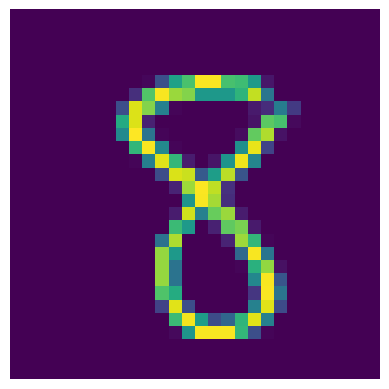

In [ ]:
plt.imshow(number_eights_train[10])
plt.axis('off');